# Project 5

## Step 1: Exploring the Enron Dataset

### Section 1: Loading the dataset 

In [1]:
# Import necessary libraries
%pylab inline
import sys
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'bonus', 'total_stock_value', 'loan_advances', 'from_poi_to_this_person', 
                 'from_this_person_to_poi', 'shared_receipt_with_poi', 'from_messages', 'to_messages'] 

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

print len(data_dict)

### Task 2: Remove outliers
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.

my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

Populating the interactive namespace from numpy and matplotlib
146


C:\Users\user\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


As shown, the dataset includes relevant data for 146 people (or entities).

### Section 2: Transforming Dataset into Pandas Dataframe for easy exploration

In [2]:
# Make data frame of the dataset
df = pd.DataFrame.from_records(list(data_dict.values()))
employees = pd.Series(list(data_dict.keys()))

# set the index of df to be the employees series:
df.set_index(employees, inplace=True)

# exclude email address because it is not necessary
df.drop('email_address', axis=1, inplace=True)

# make data entry to be numeric
df_new = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).copy()

# Chekc how many null entries are in the dataset
print df_new.isnull().sum()

# to the df, or remove rows, i.e. employees, from the df
# Replace NaN values with 0
df_new.replace('NaN', 0, inplace = True)

bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
exercised_stock_options       44
expenses                      51
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       60
to_messages                   60
total_payments                21
total_stock_value             20
dtype: int64


There were many entries with no values. In this context, they are mostly likely to be 0. Therefore, I simply put 0 for all NaN cases. Also, I dropped the email address feature right away since it will not be of any help in my research.

### Section 3: Finding Outliers

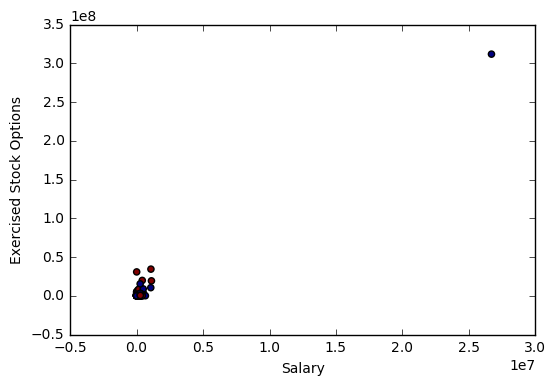

In [3]:
plt.scatter(df_new['salary'], df_new['exercised_stock_options'], c=df_new['poi'])
plt.xlabel('Salary')
plt.ylabel('Exercised Stock Options')

There is a clear outlier as shown in the graph. The outlier is 'TOTAL.' Quite naturally, this is an outlier that is not needed for this research. Therefore it is removed.

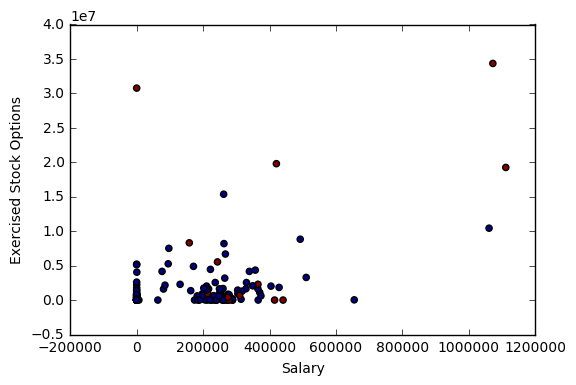

In [4]:
# Remove Total from the dataframe
df_new.drop(df_new.index[df_new.index.get_loc('TOTAL')], inplace=True)

plt.scatter(df_new['salary'], df_new['exercised_stock_options'], c=df_new['poi'])
plt.xlabel('Salary')
plt.ylabel('Exercised Stock Options')


bonus


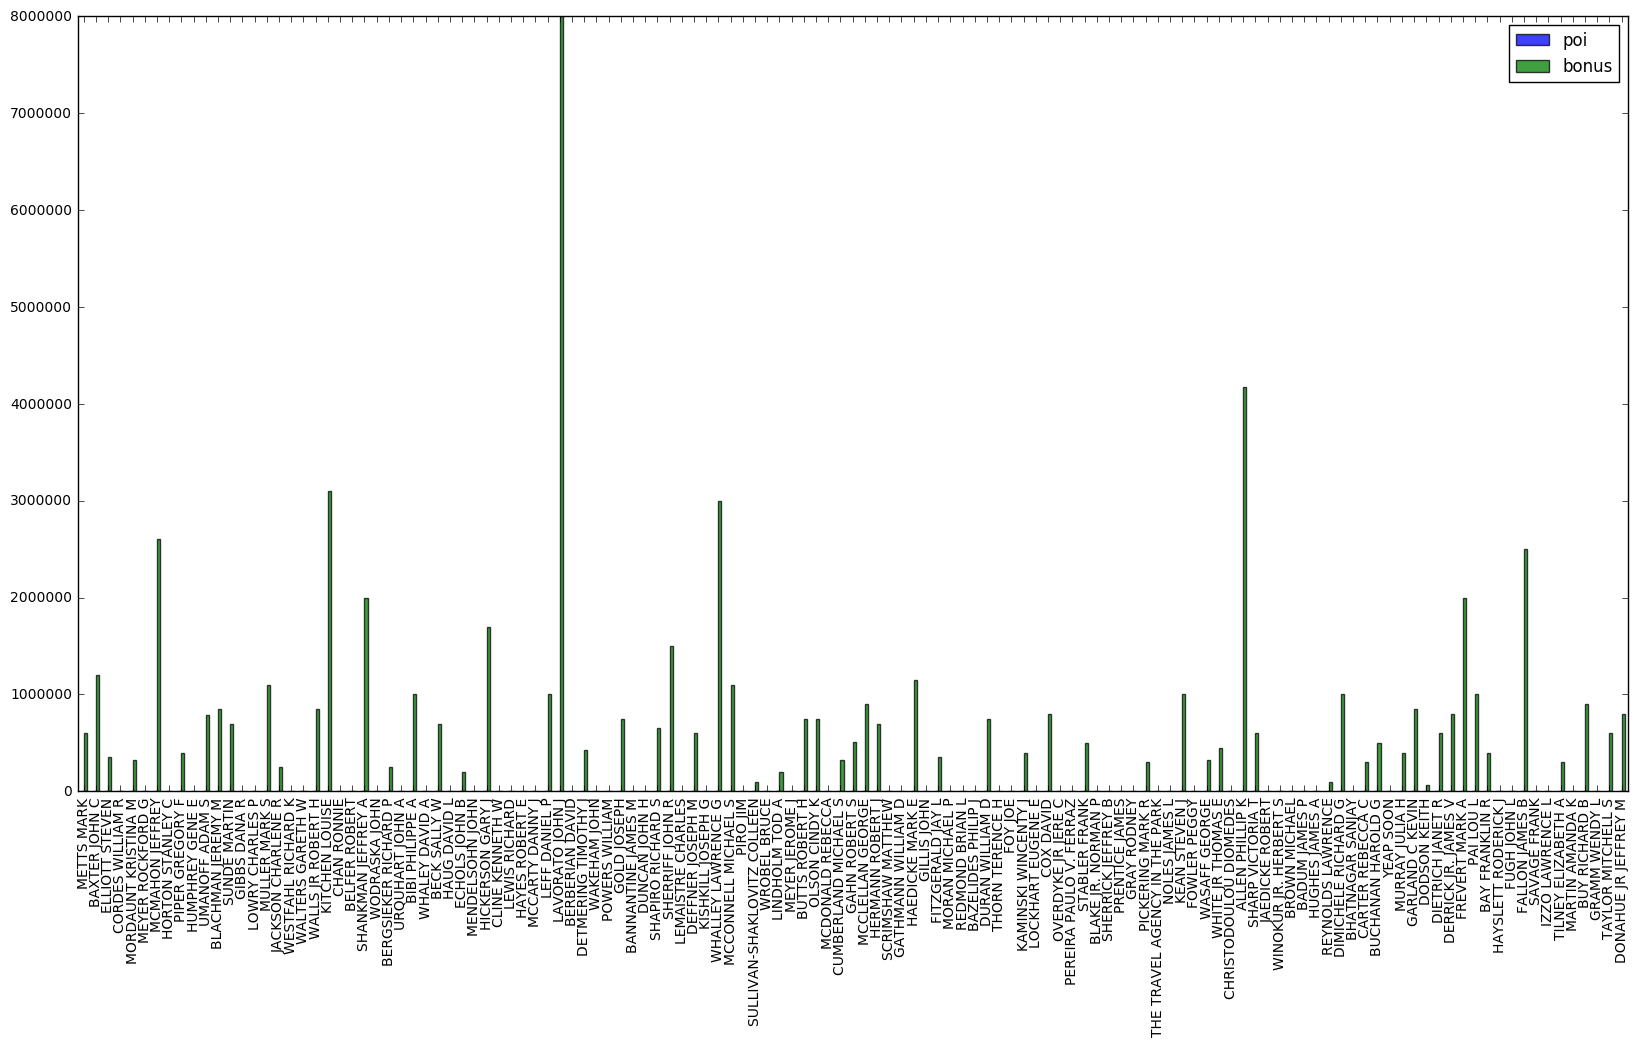

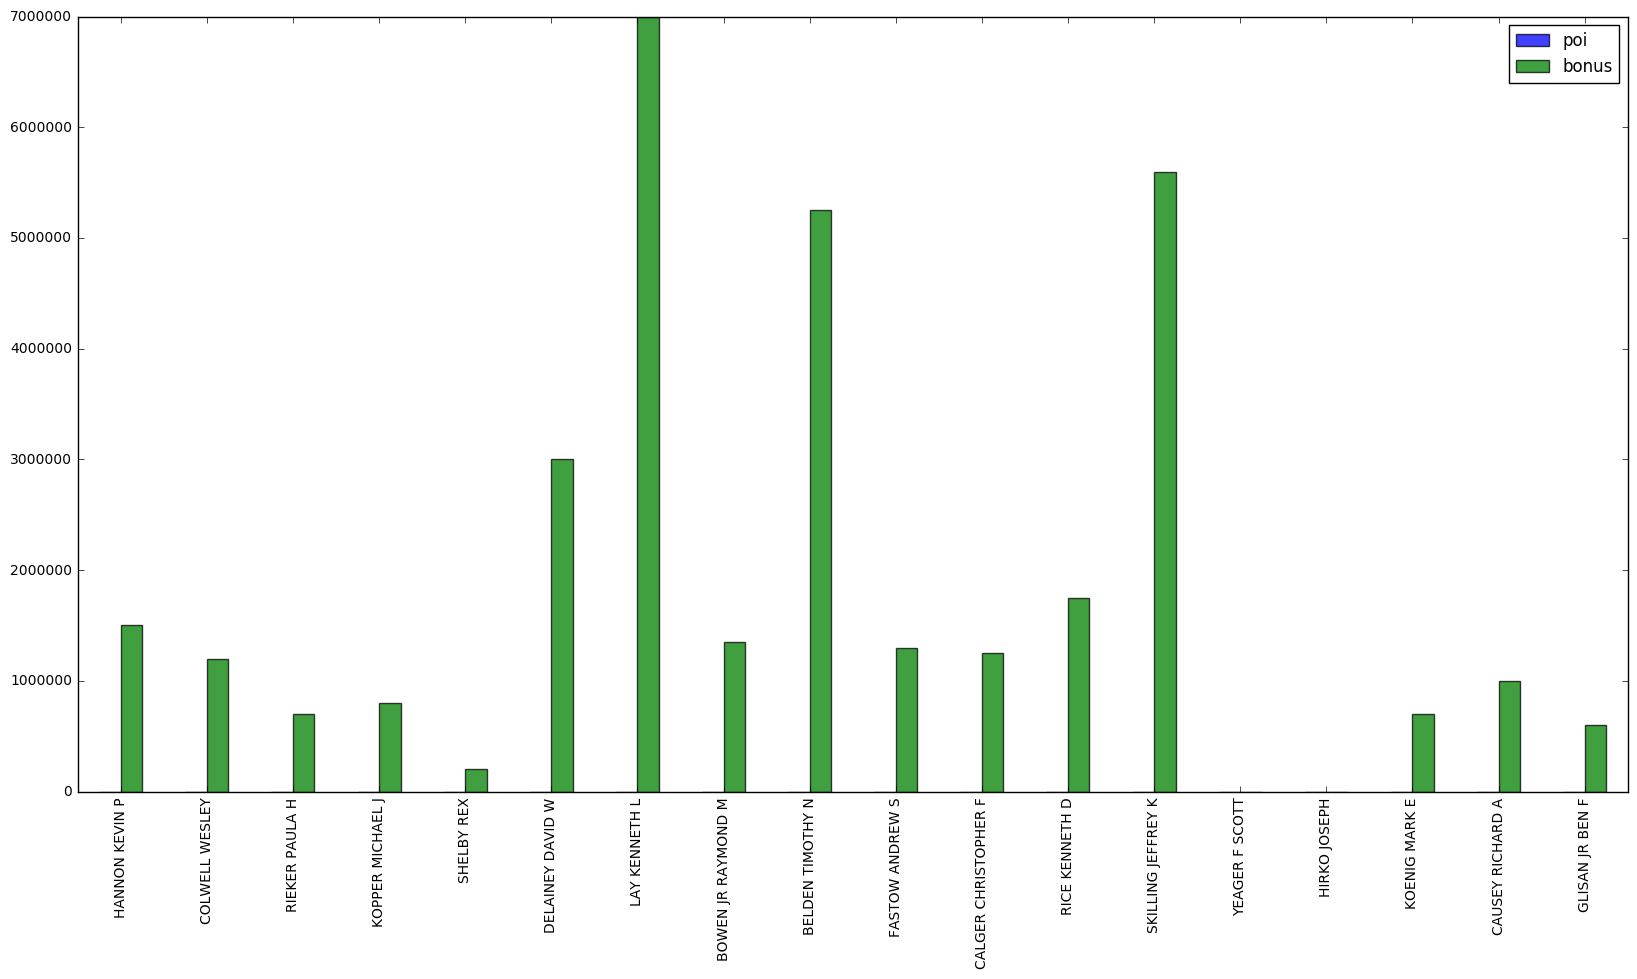


deferral_payments


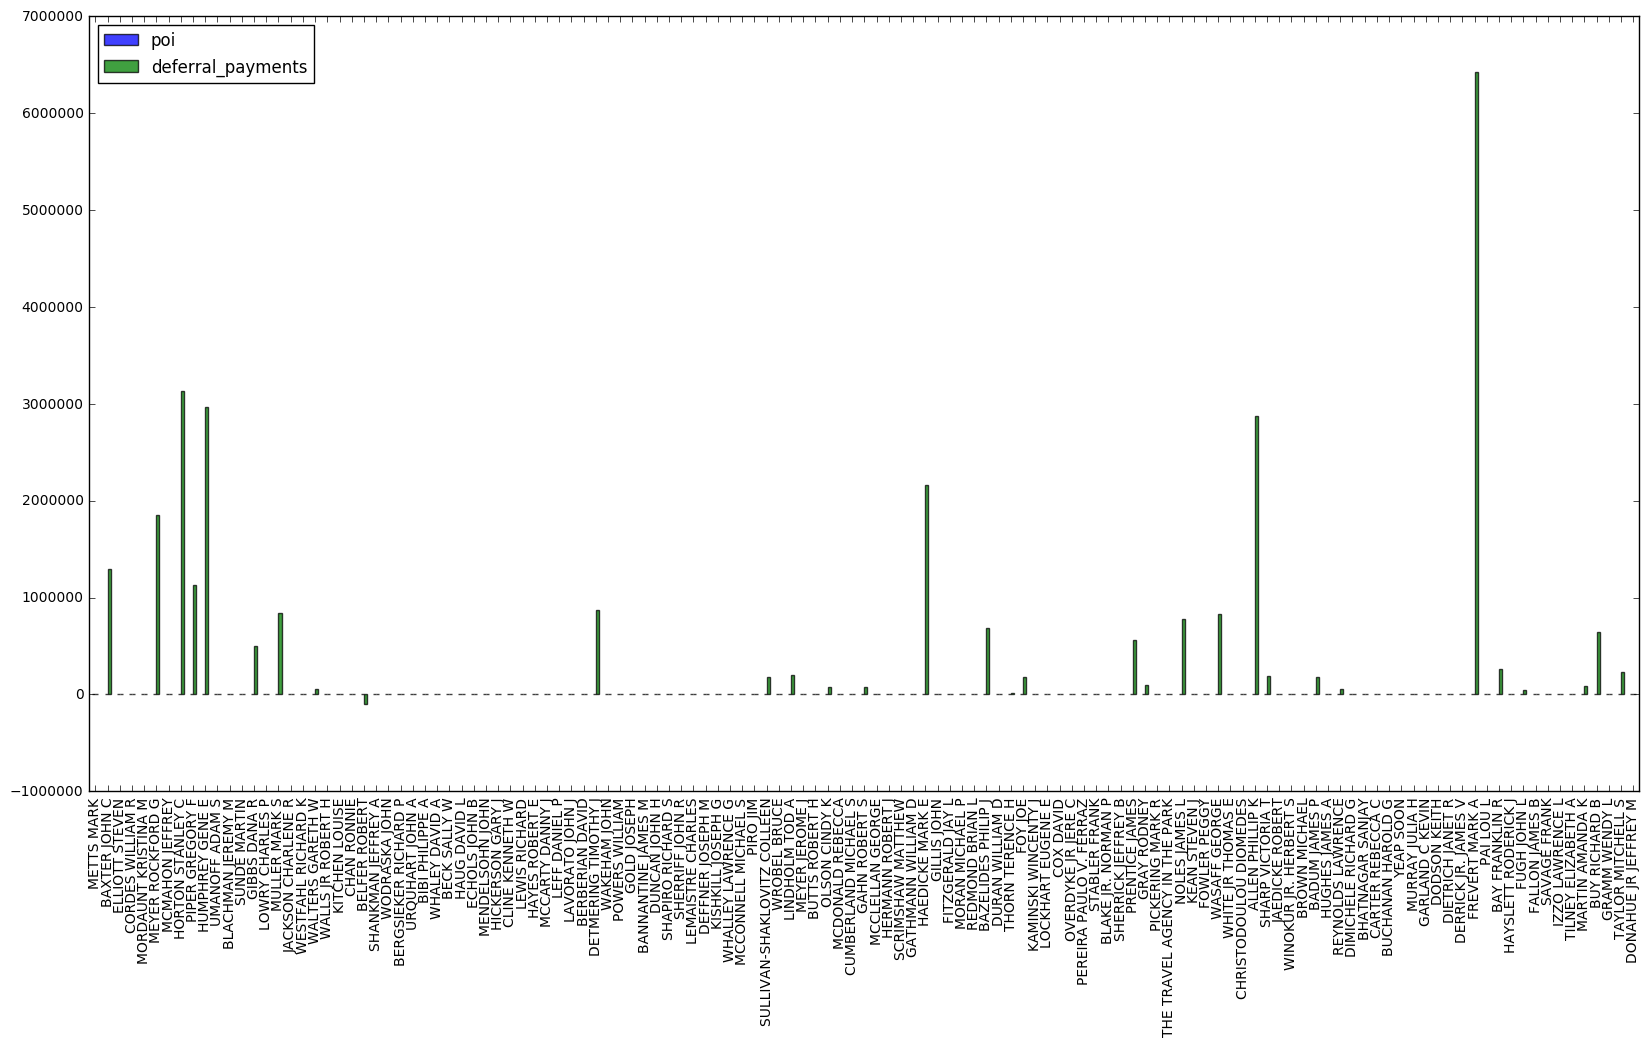

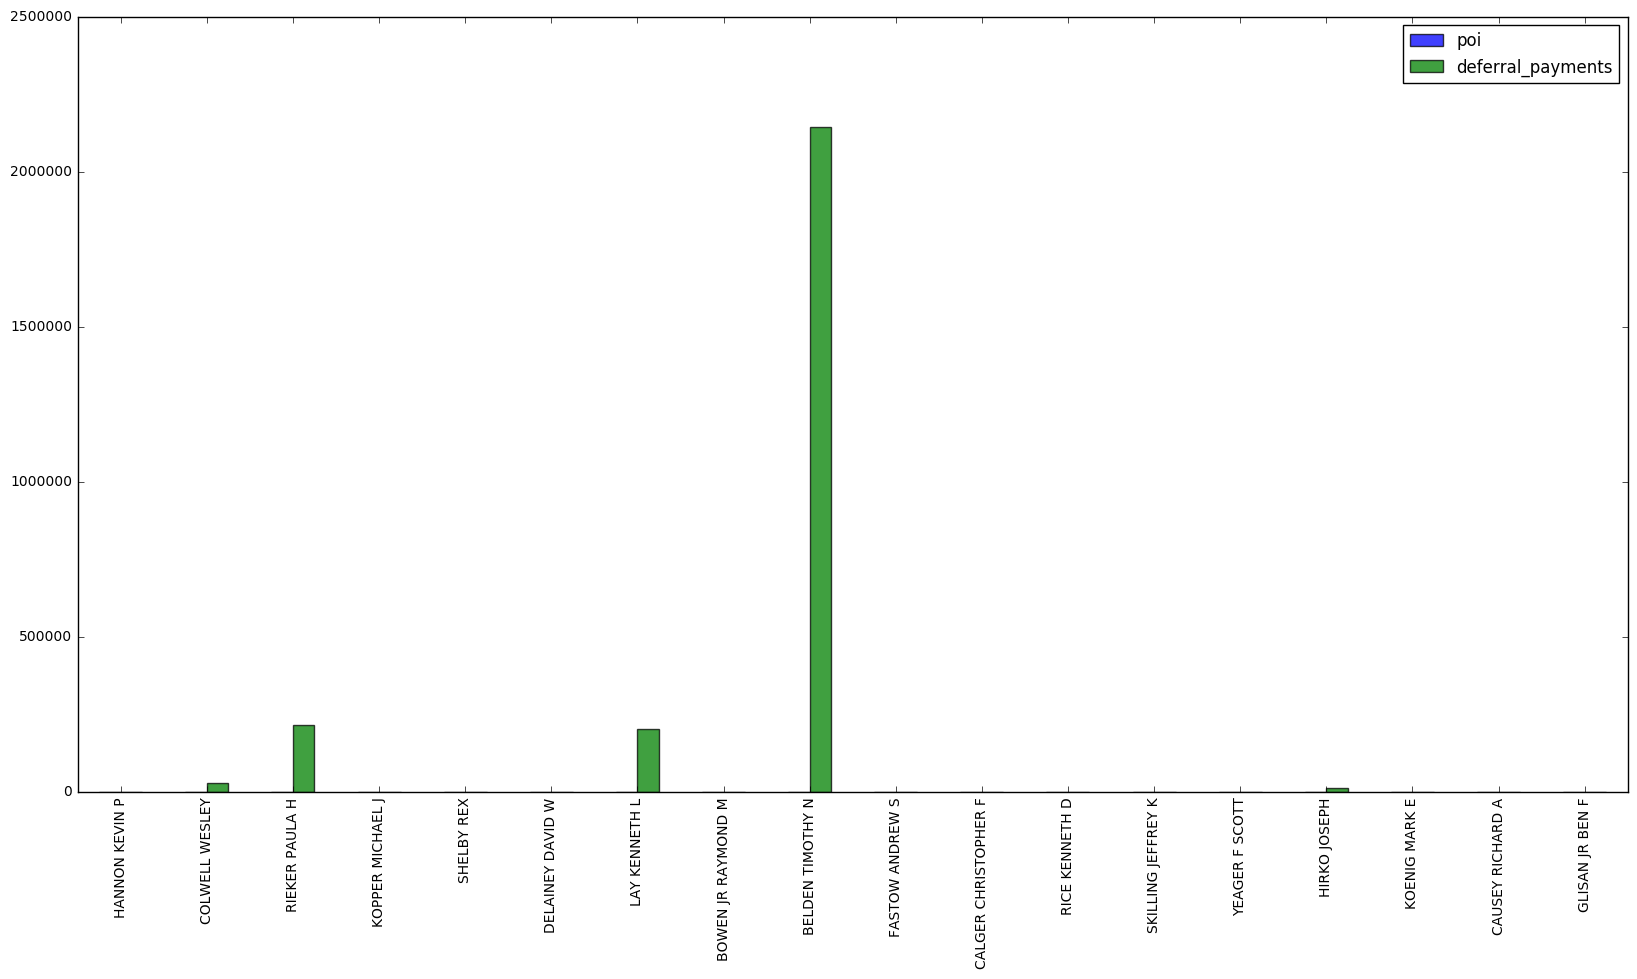


deferred_income


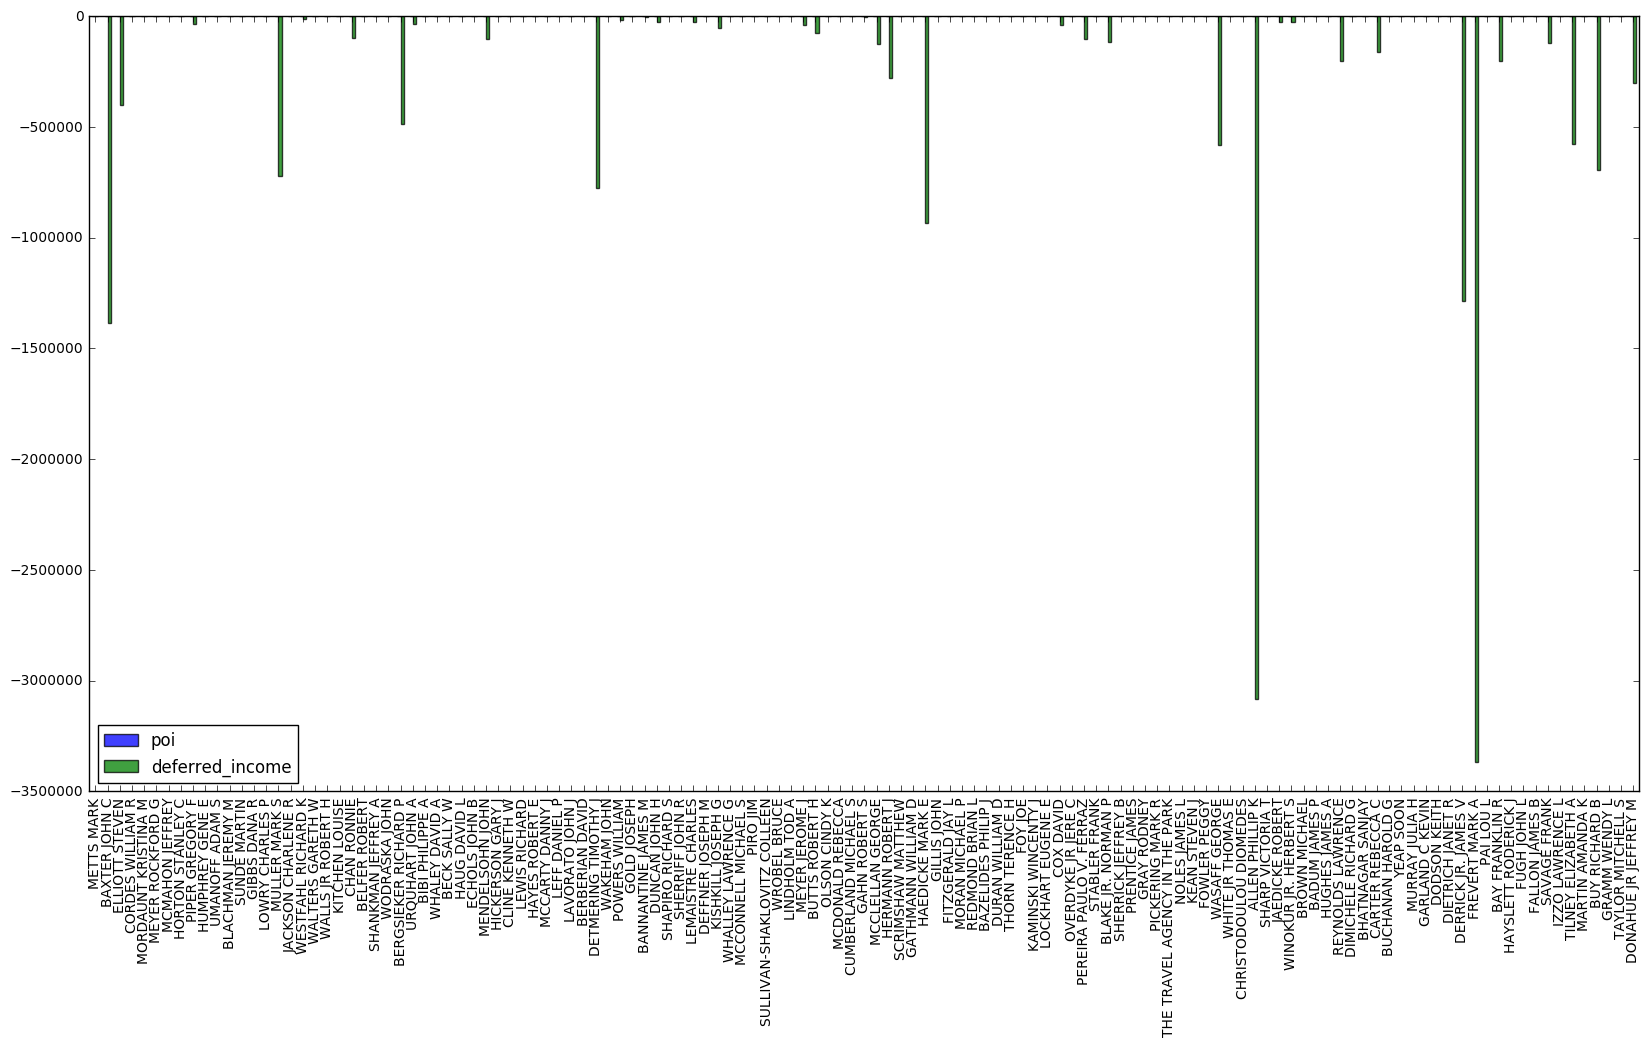

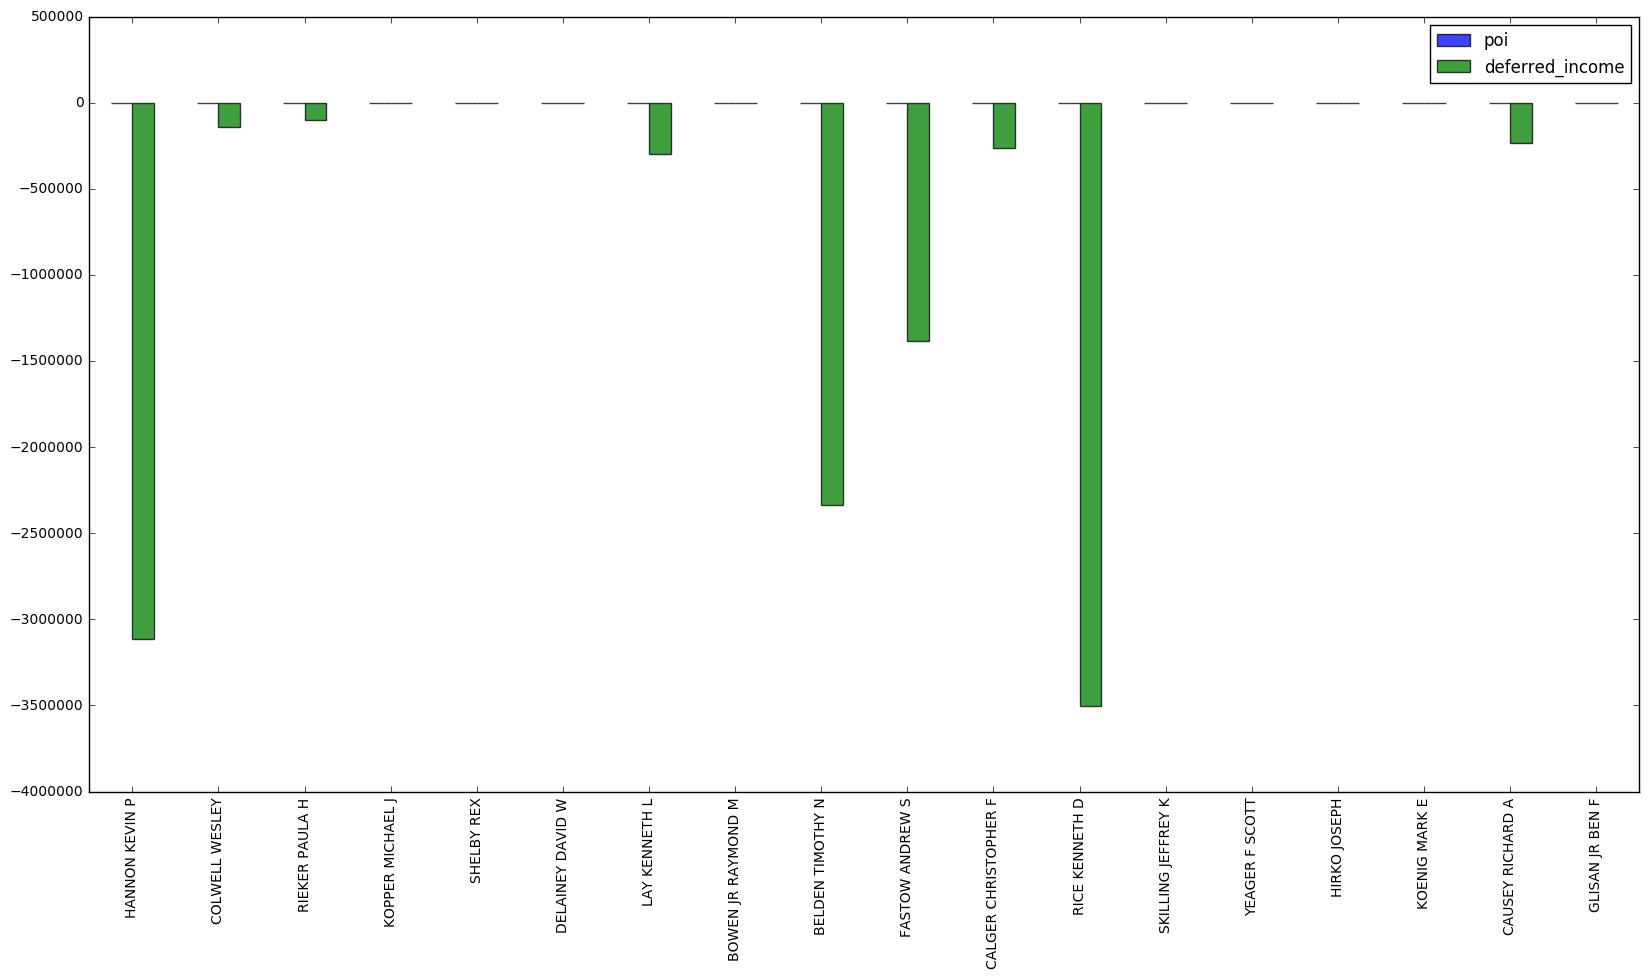


director_fees


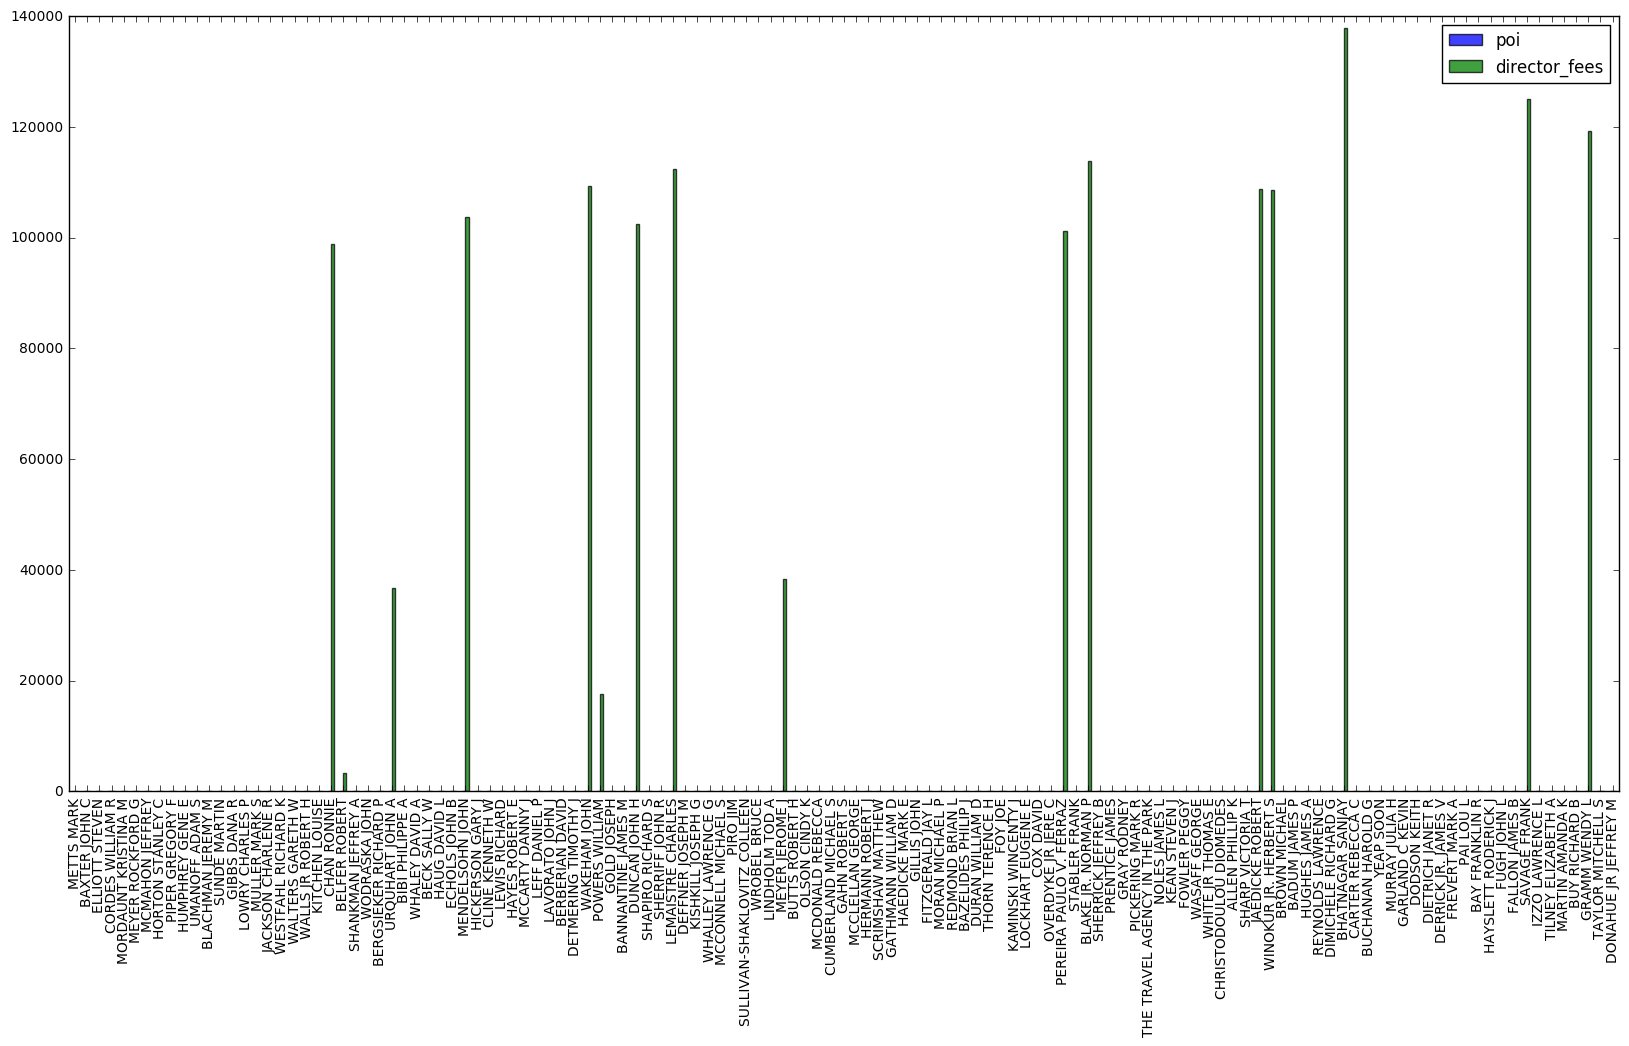

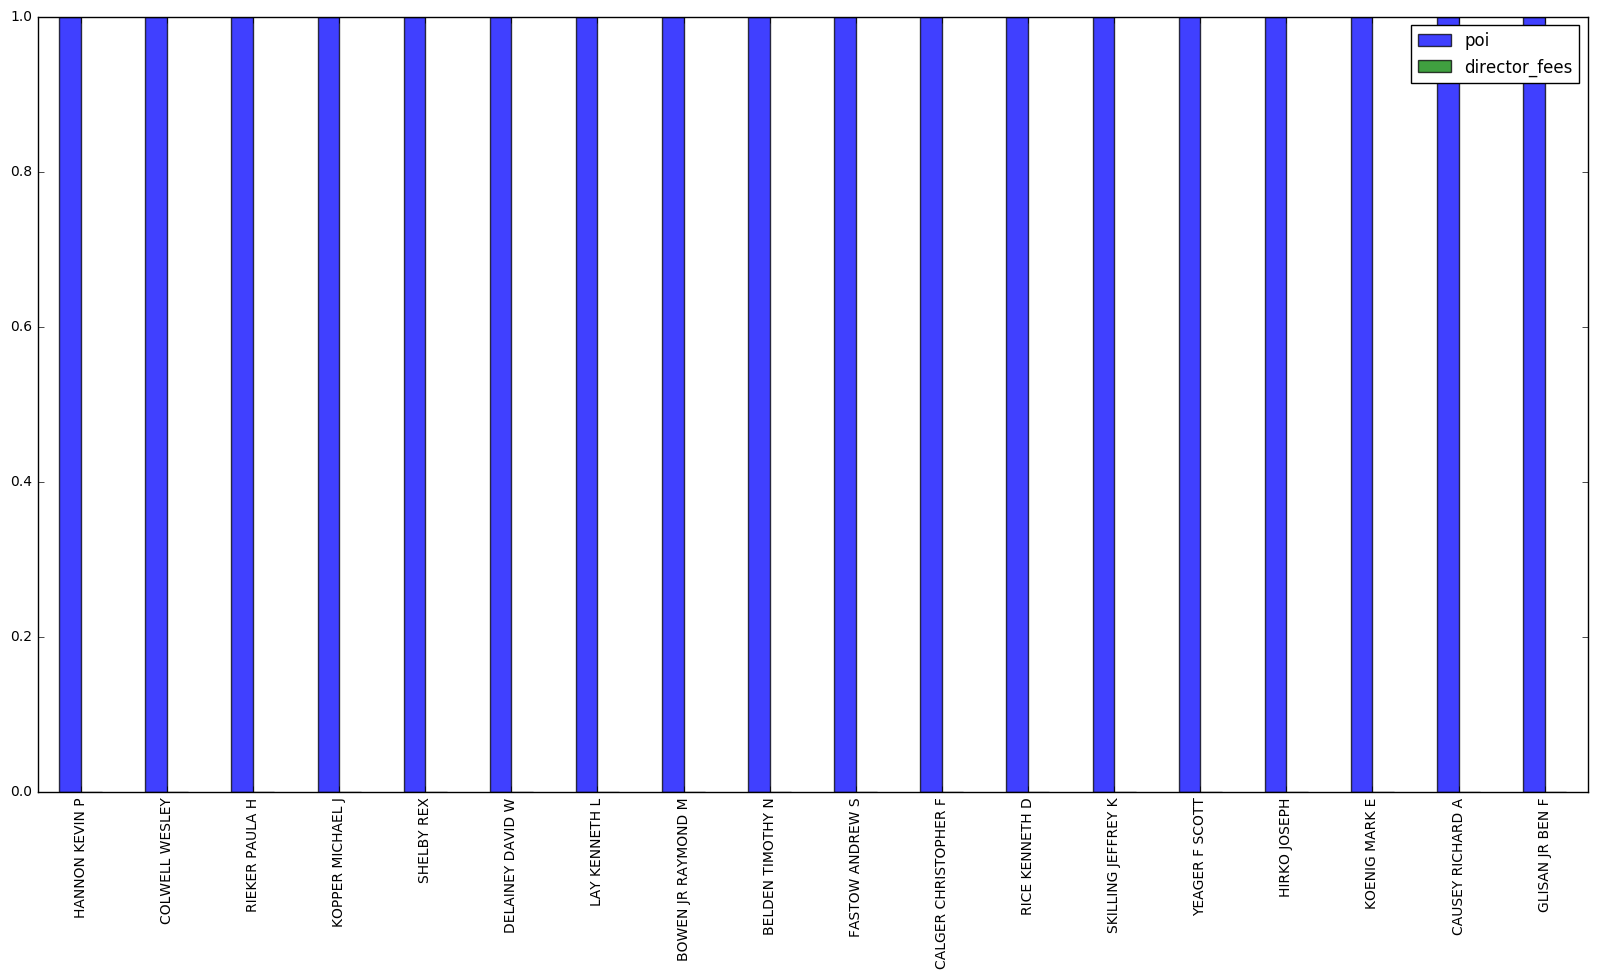


exercised_stock_options


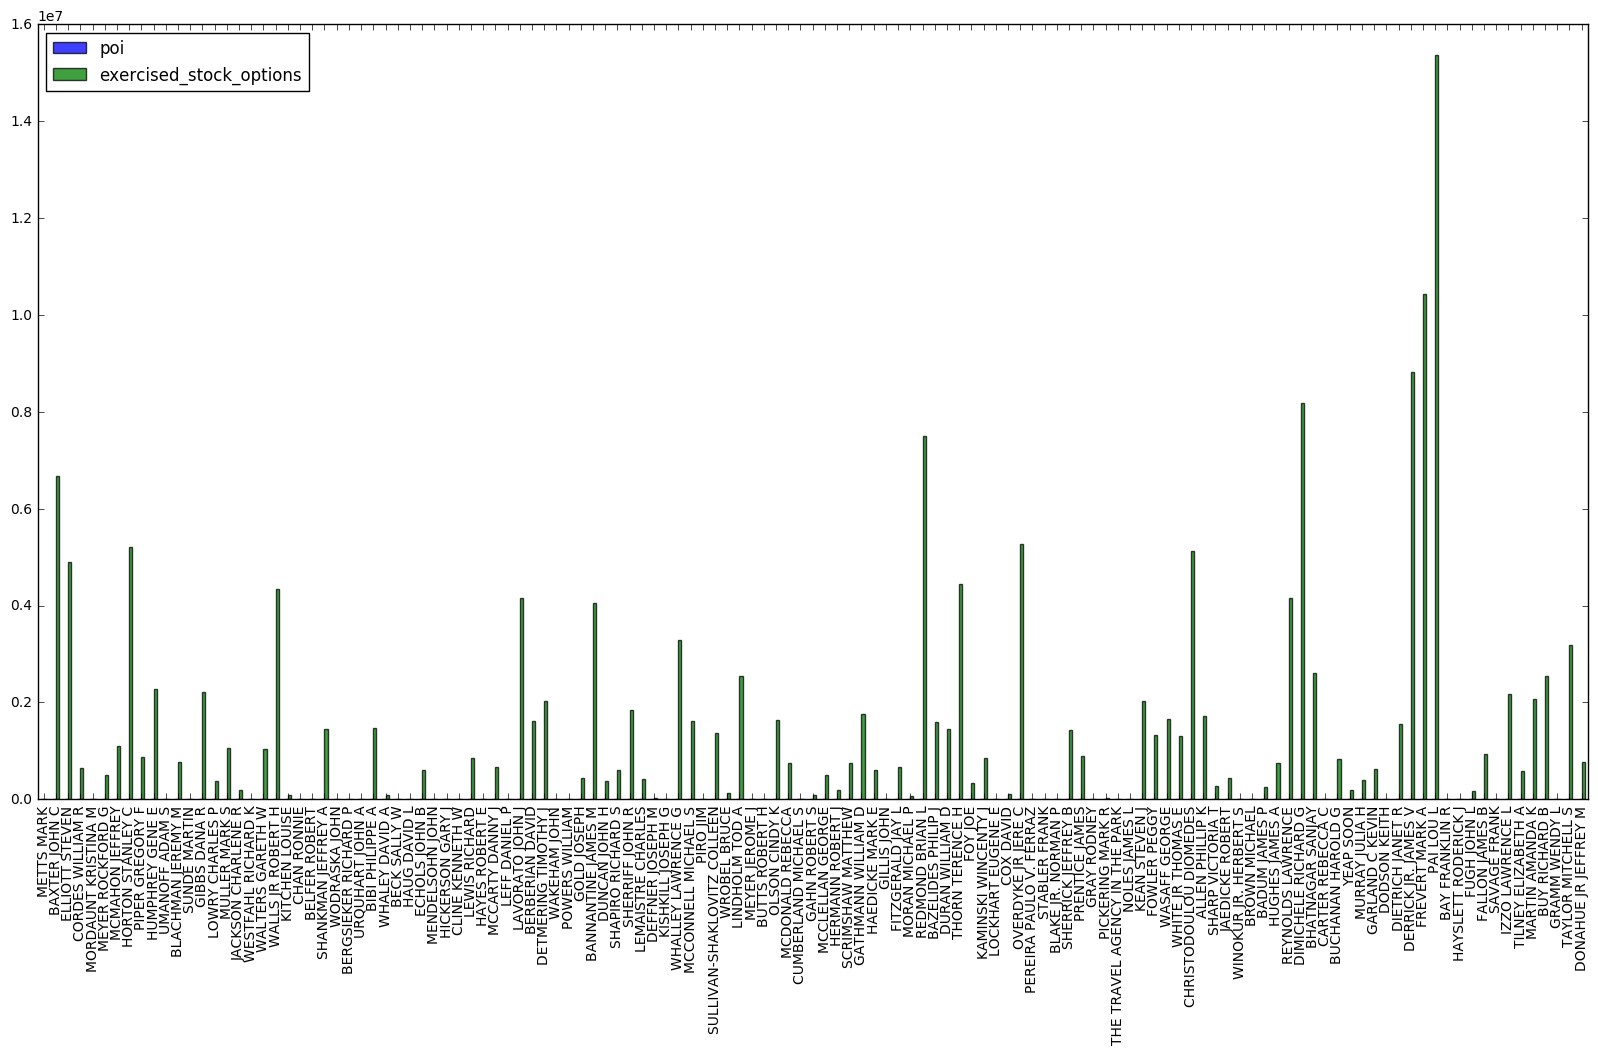

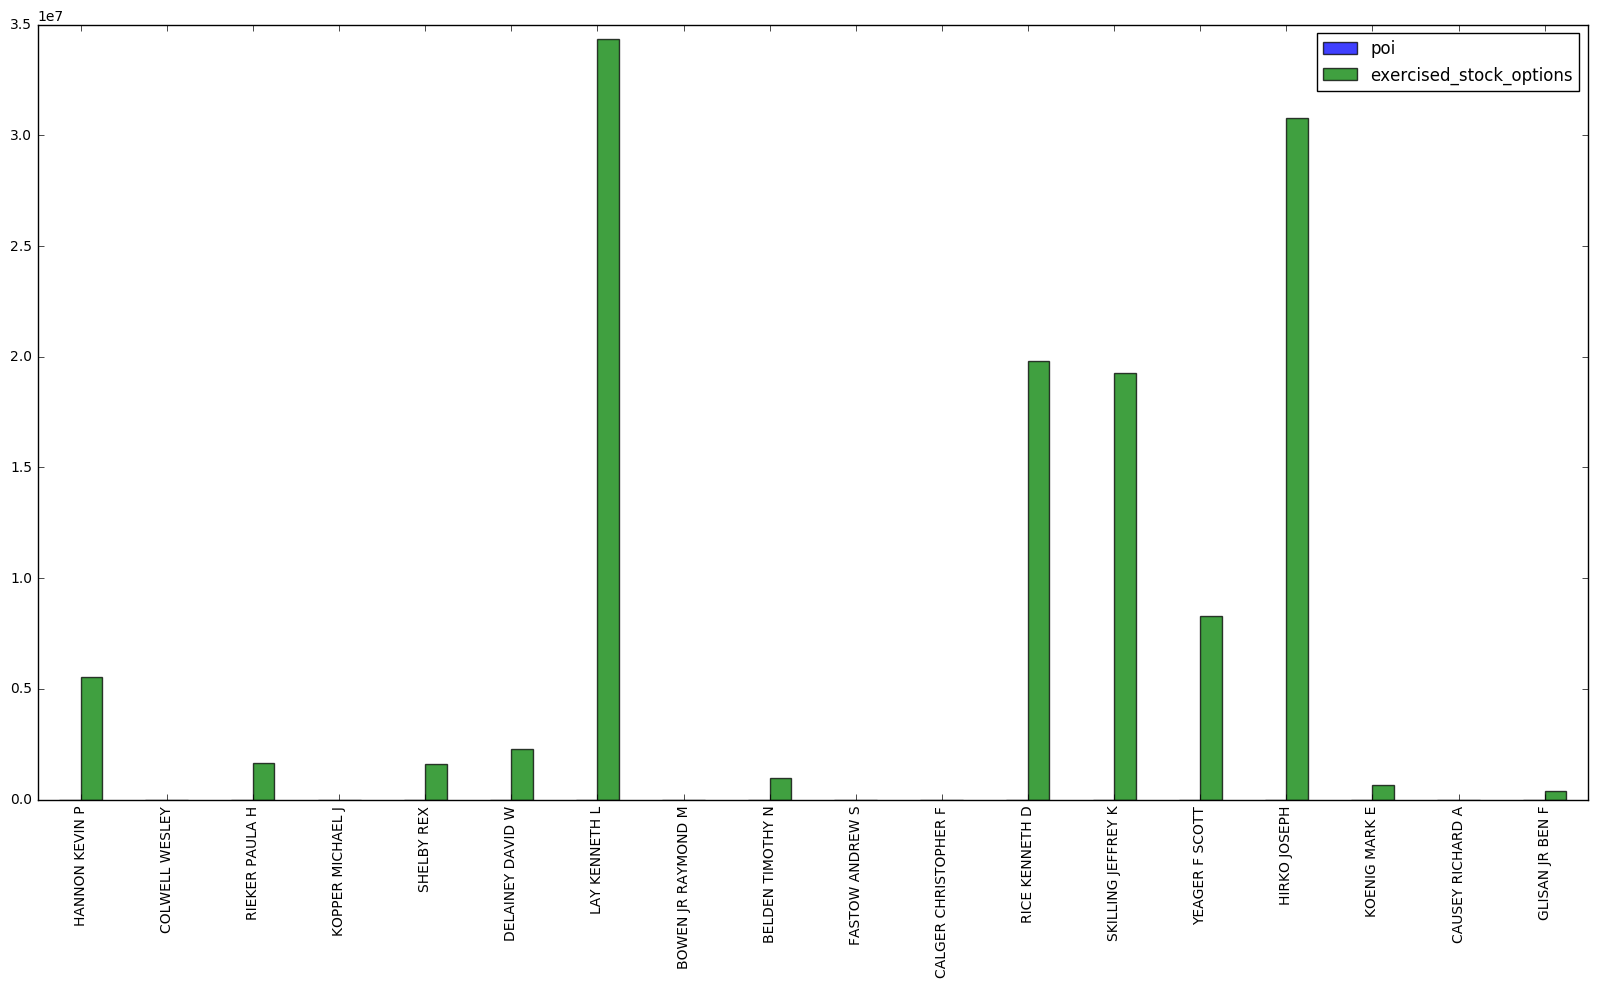


expenses


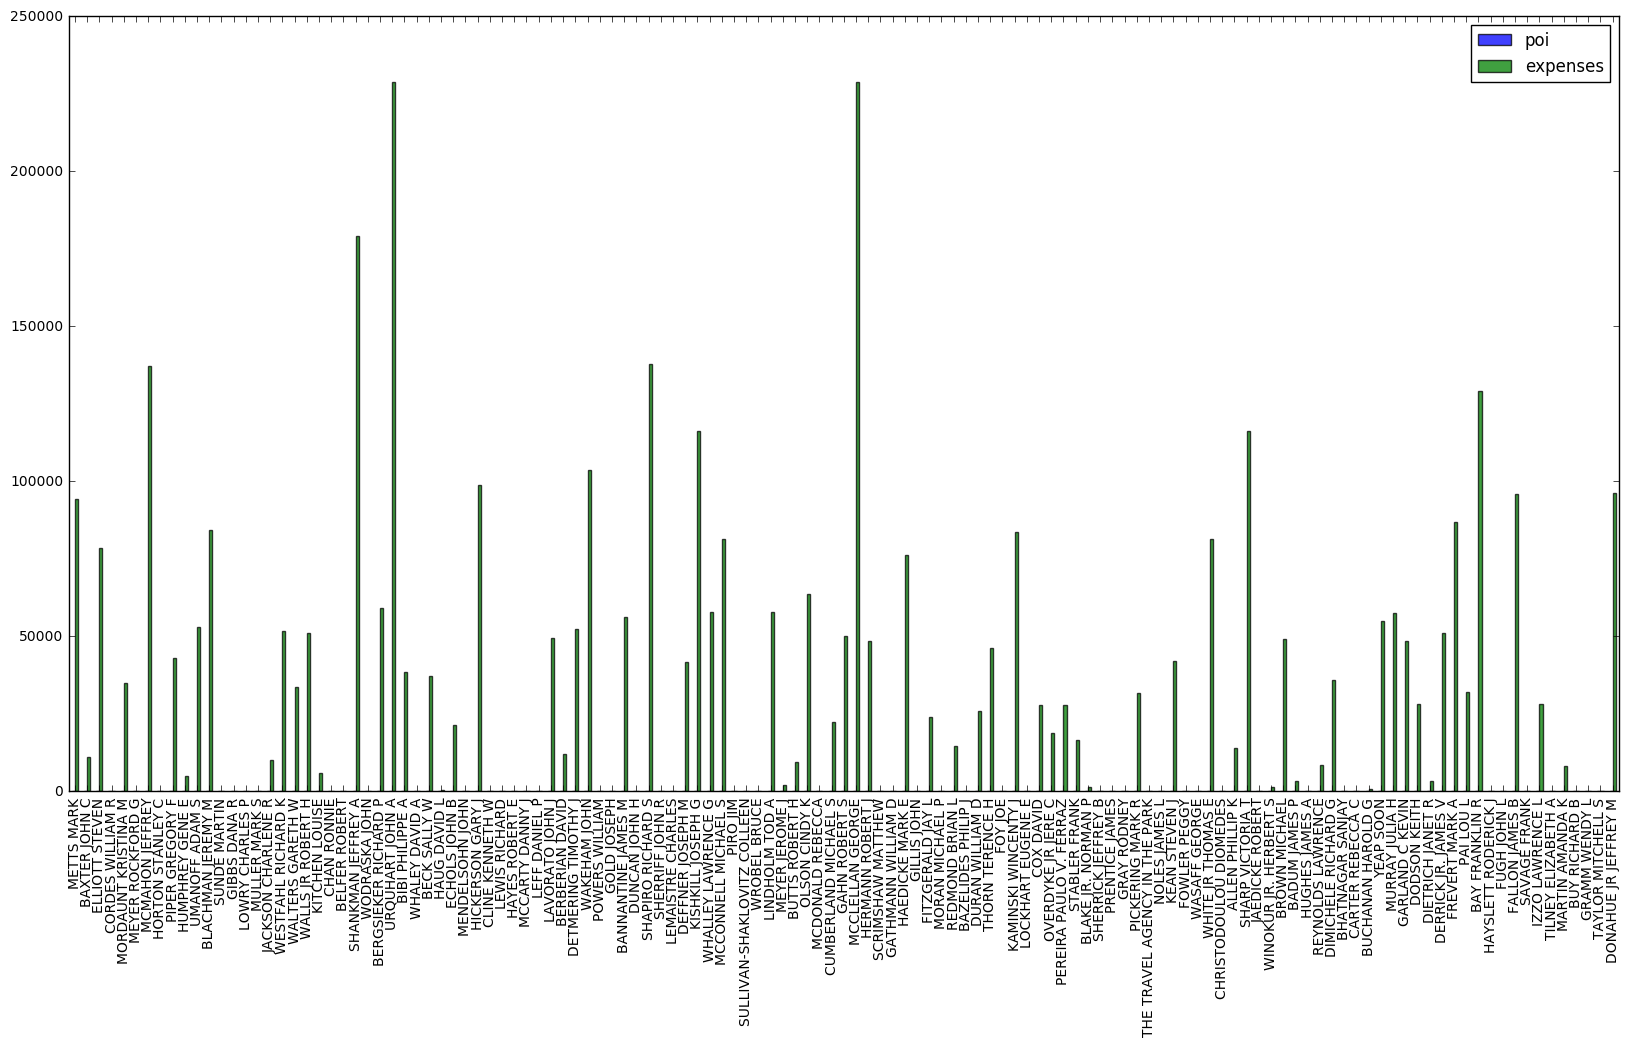

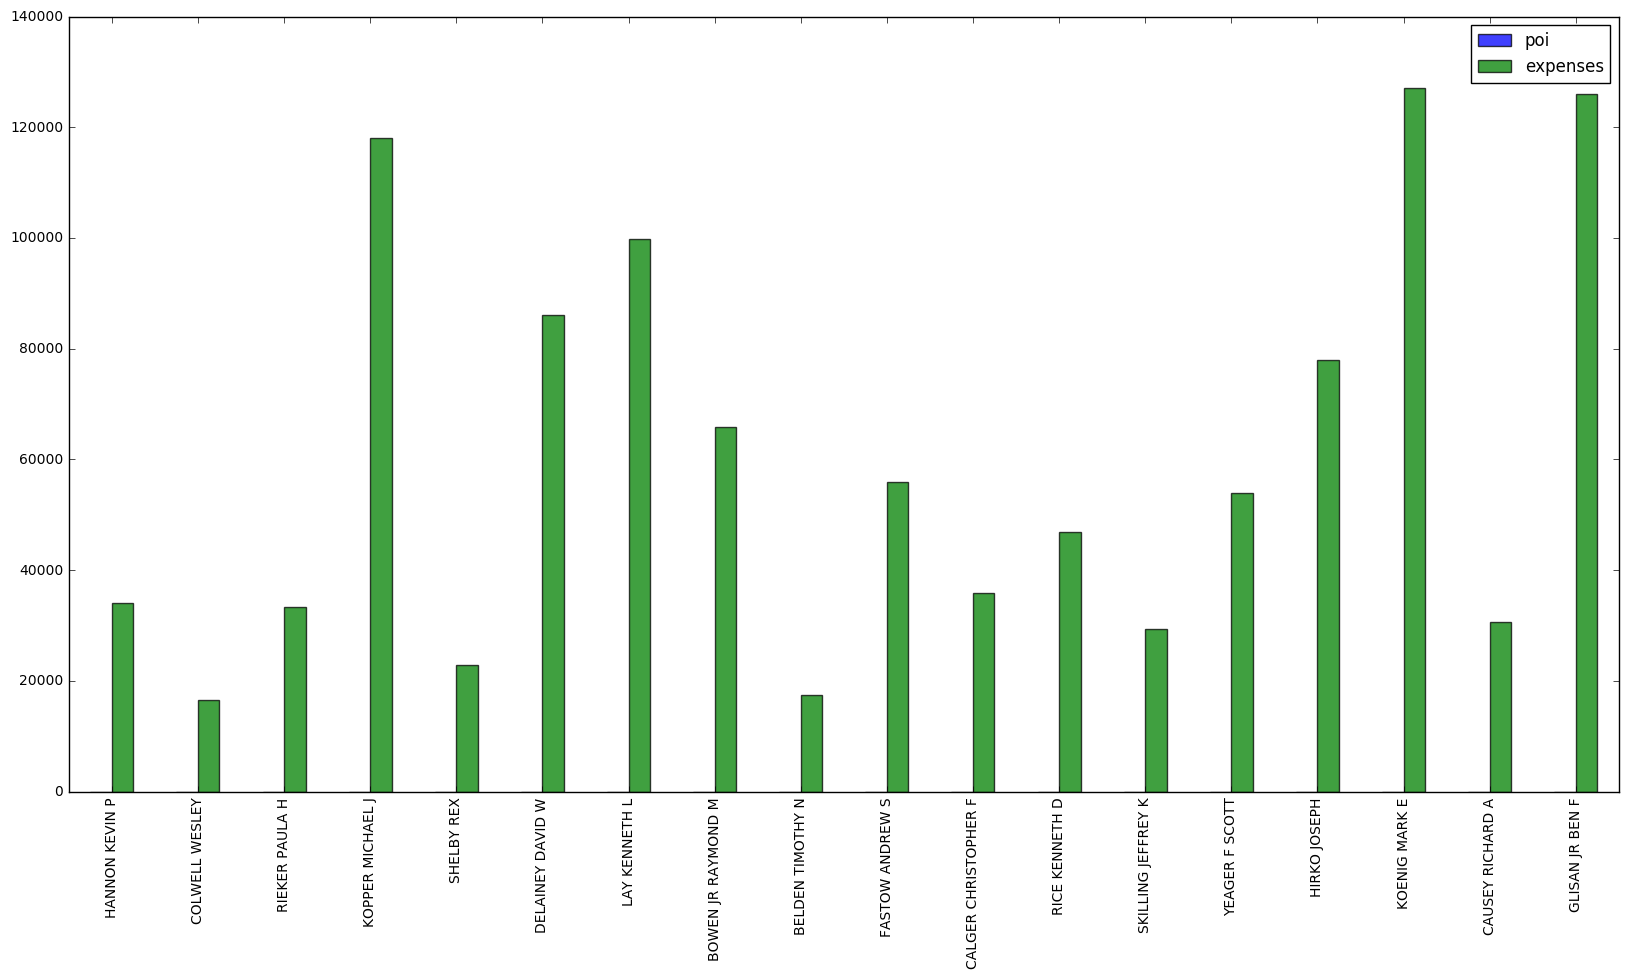


from_messages


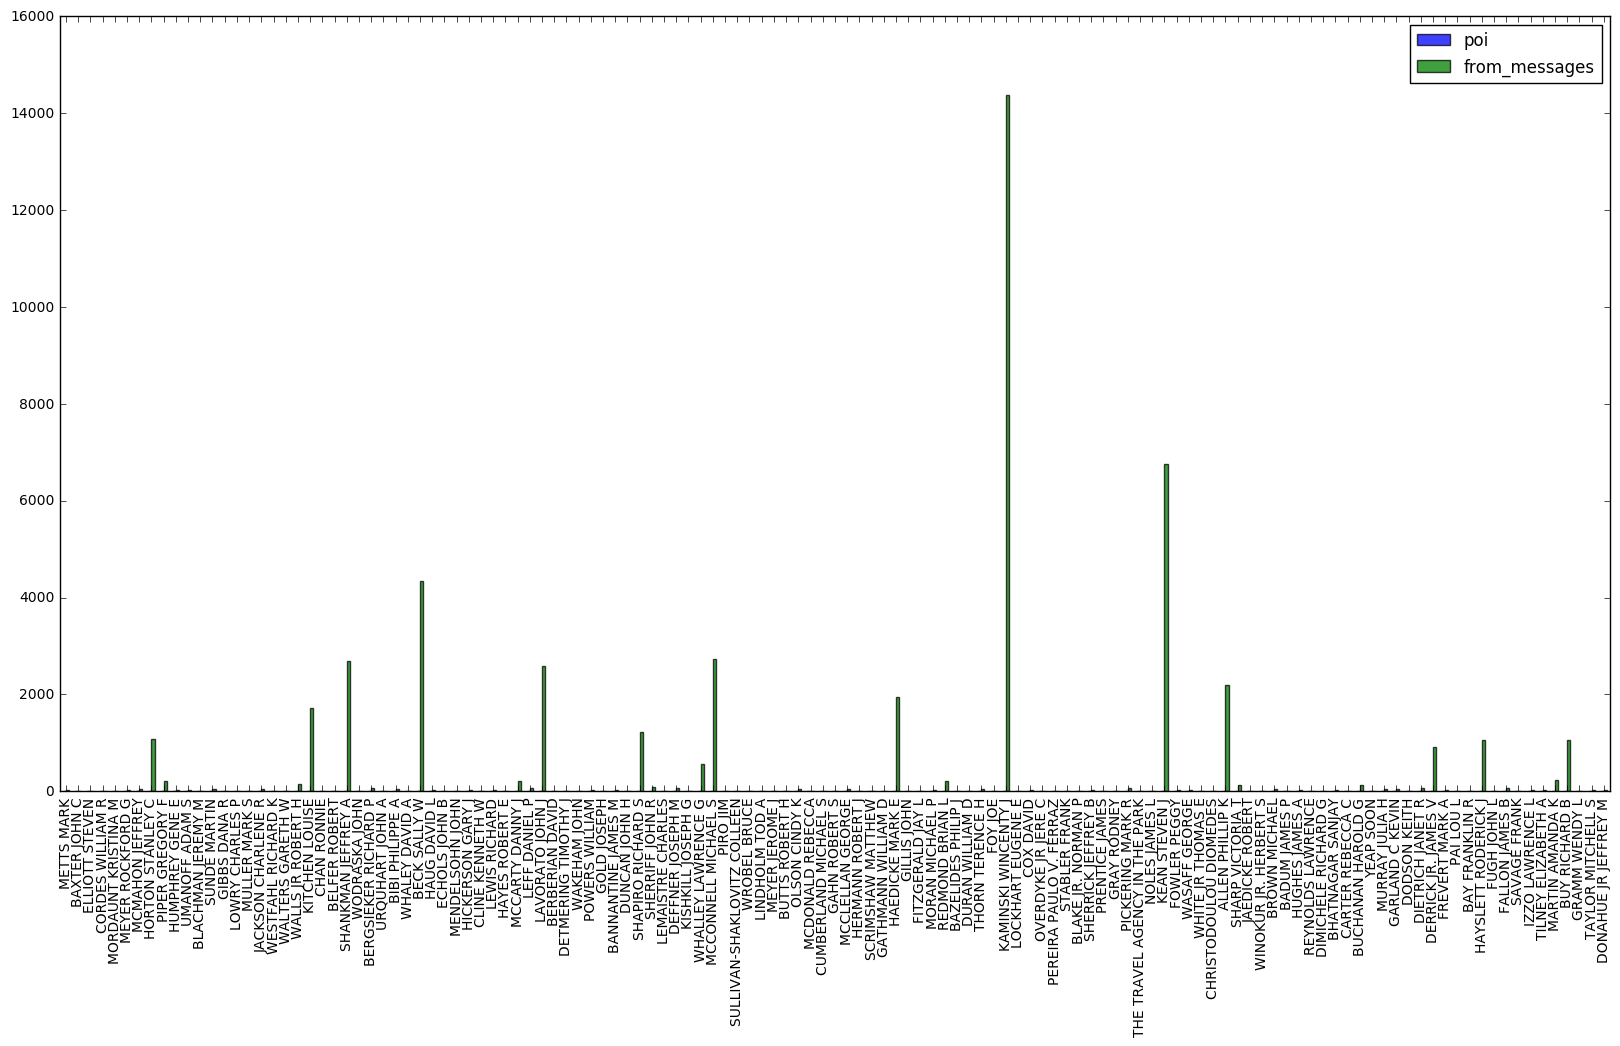

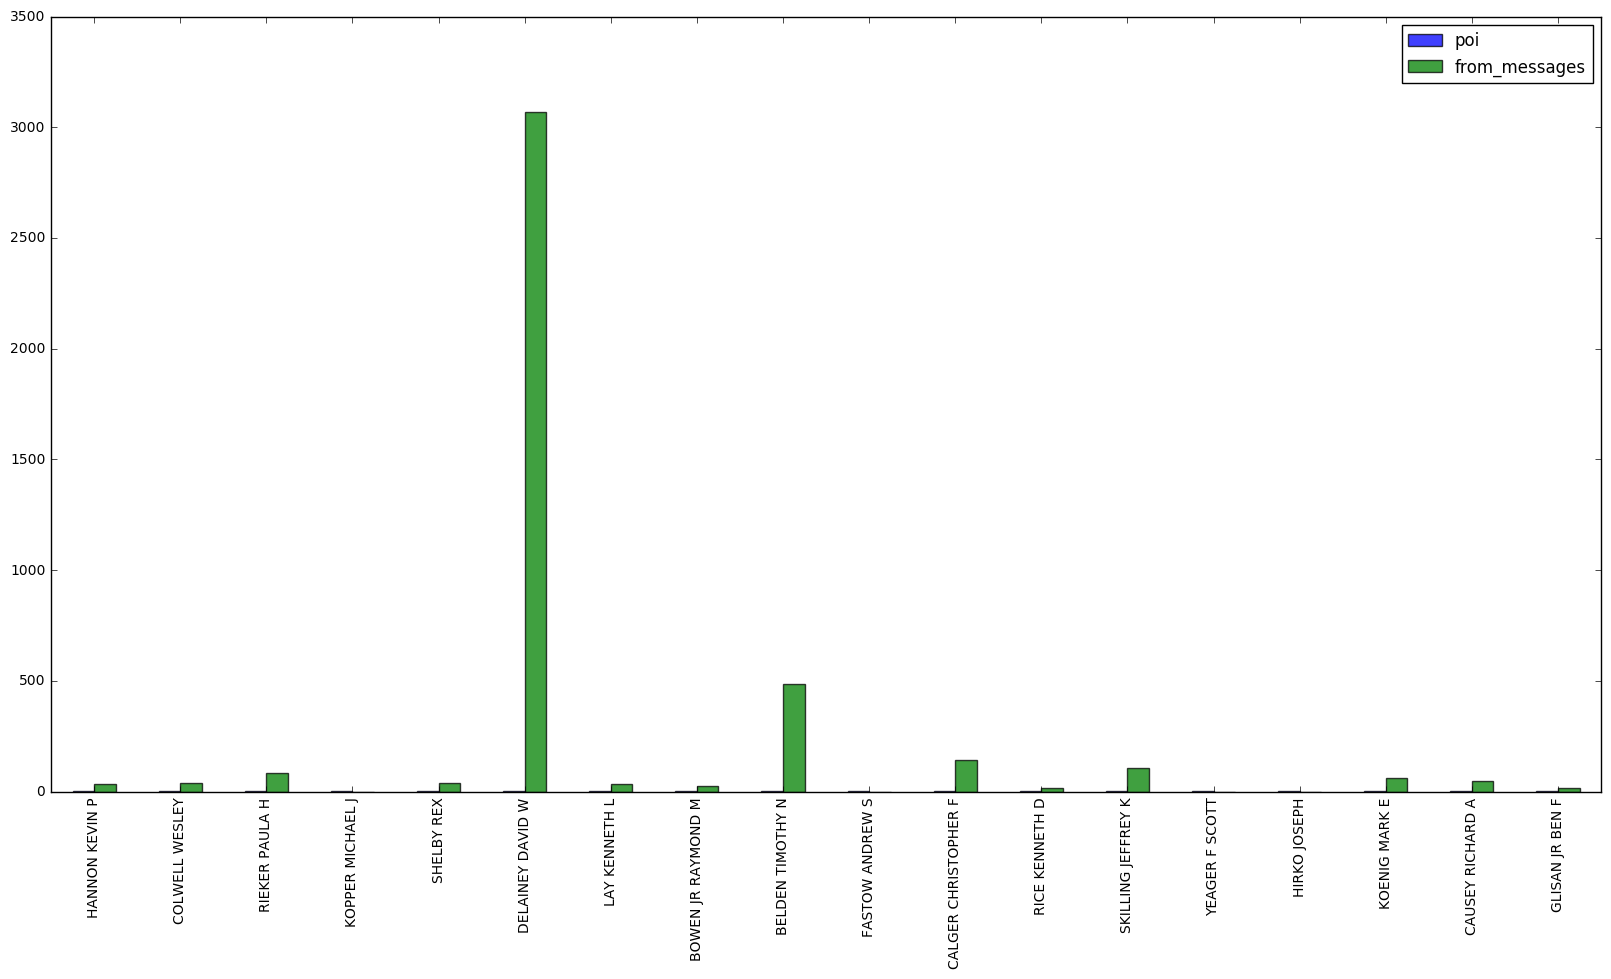


from_poi_to_this_person


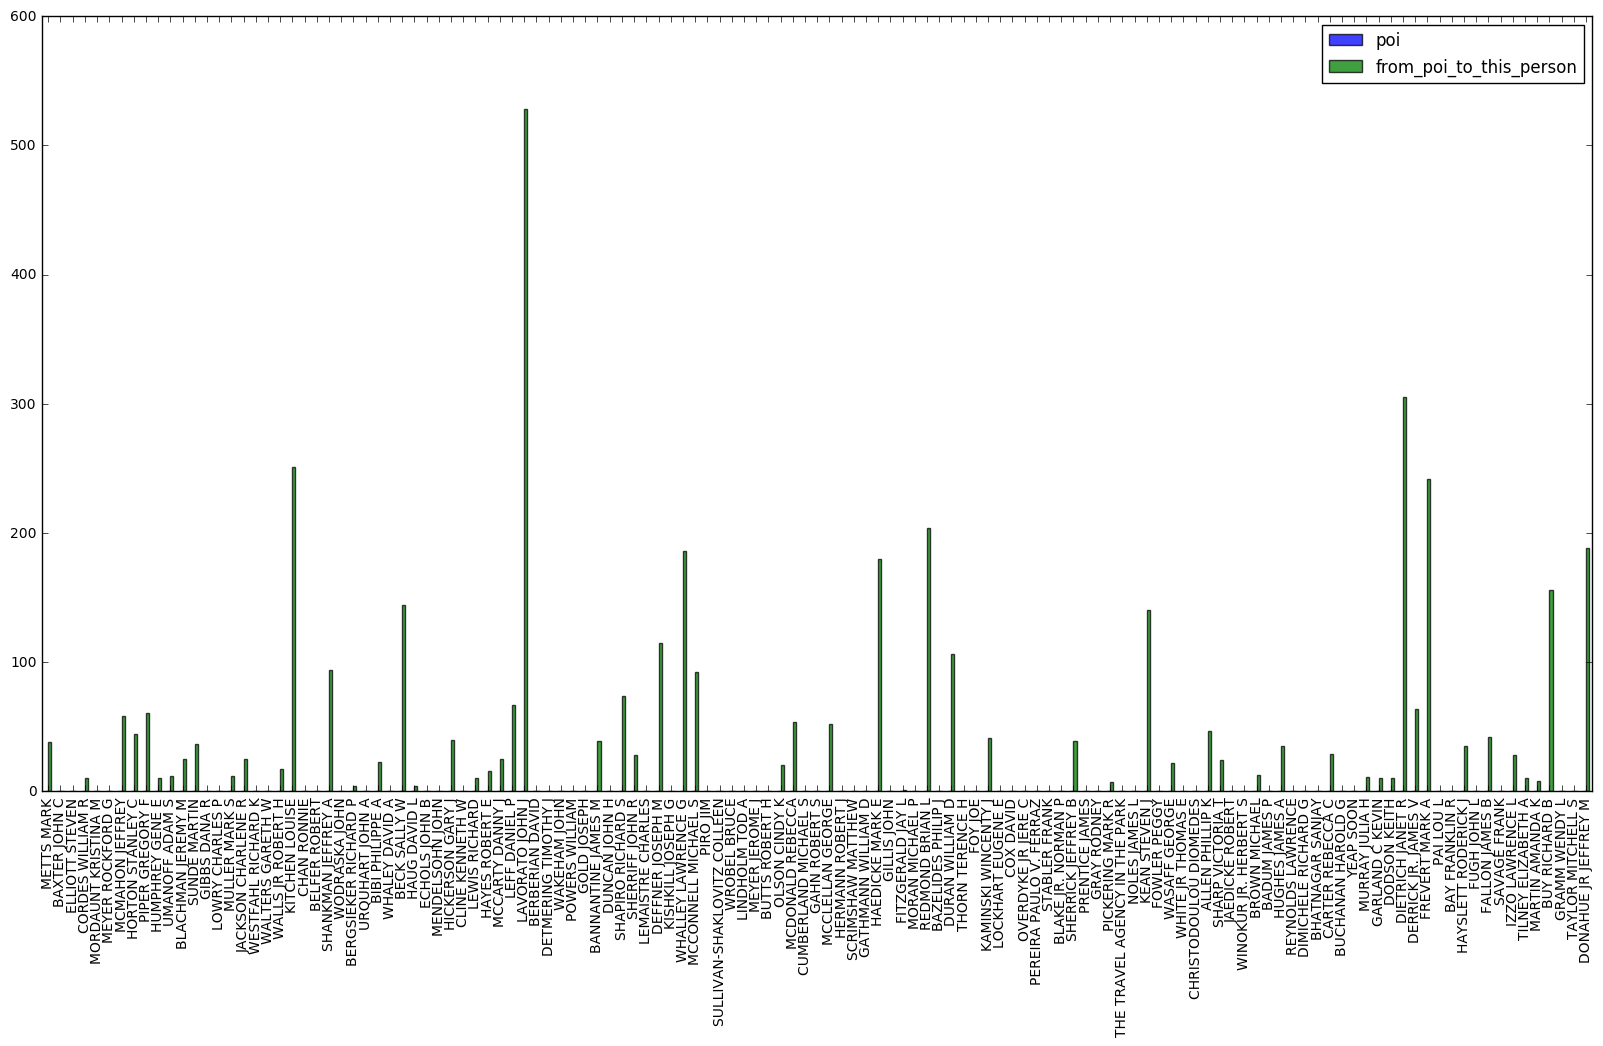

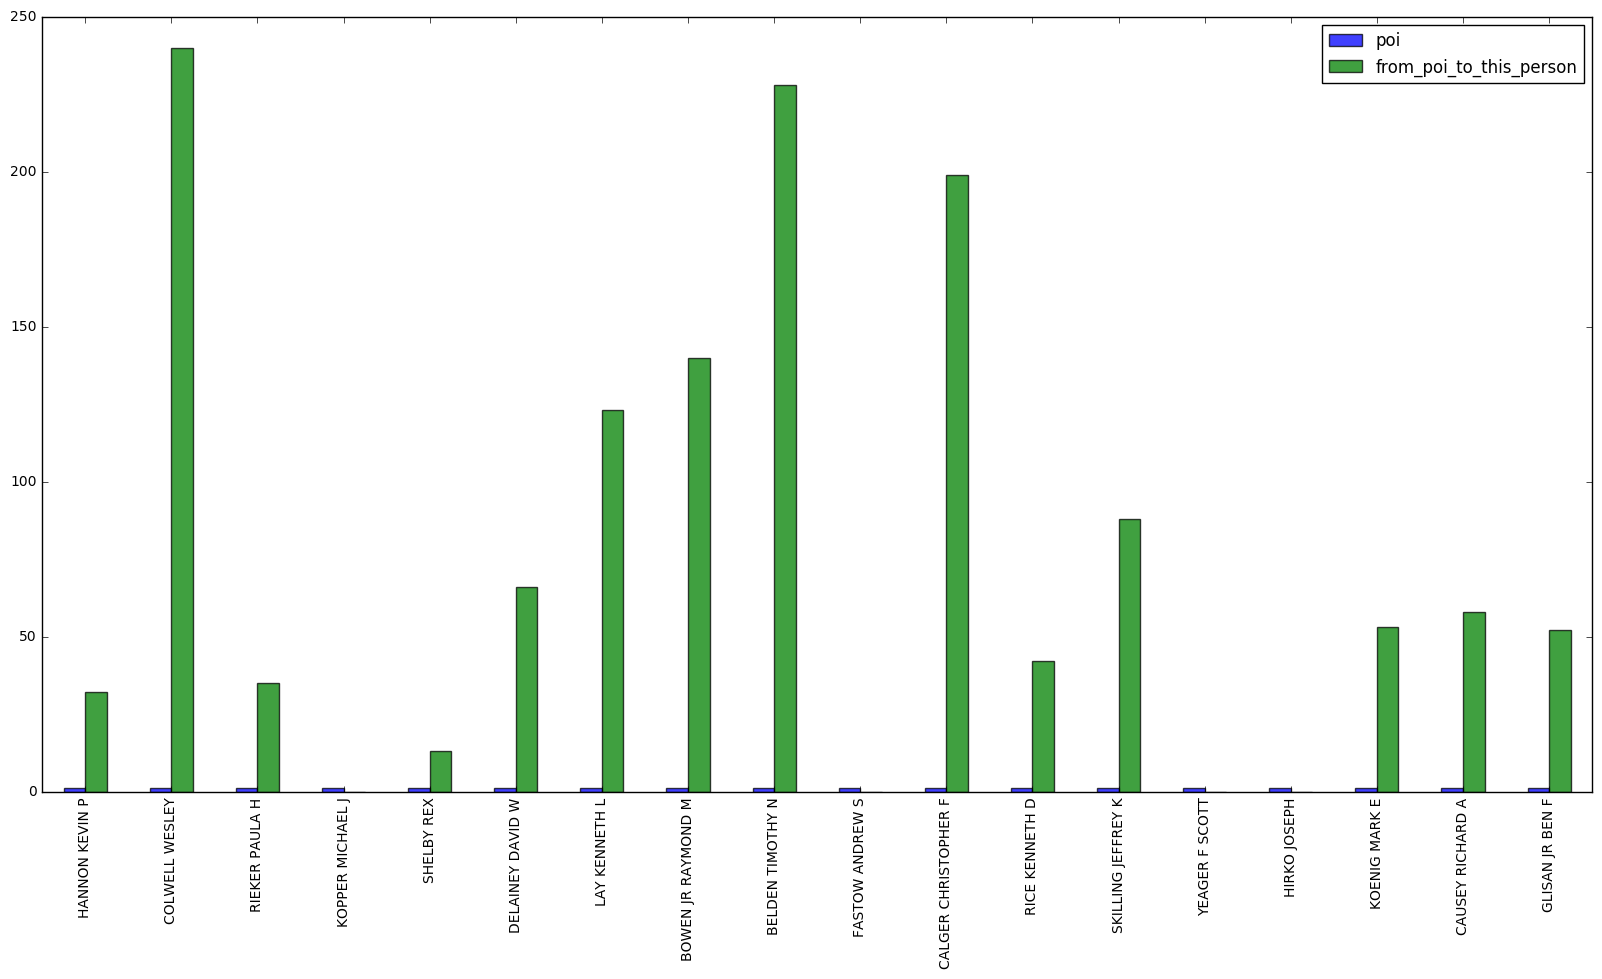


from_this_person_to_poi


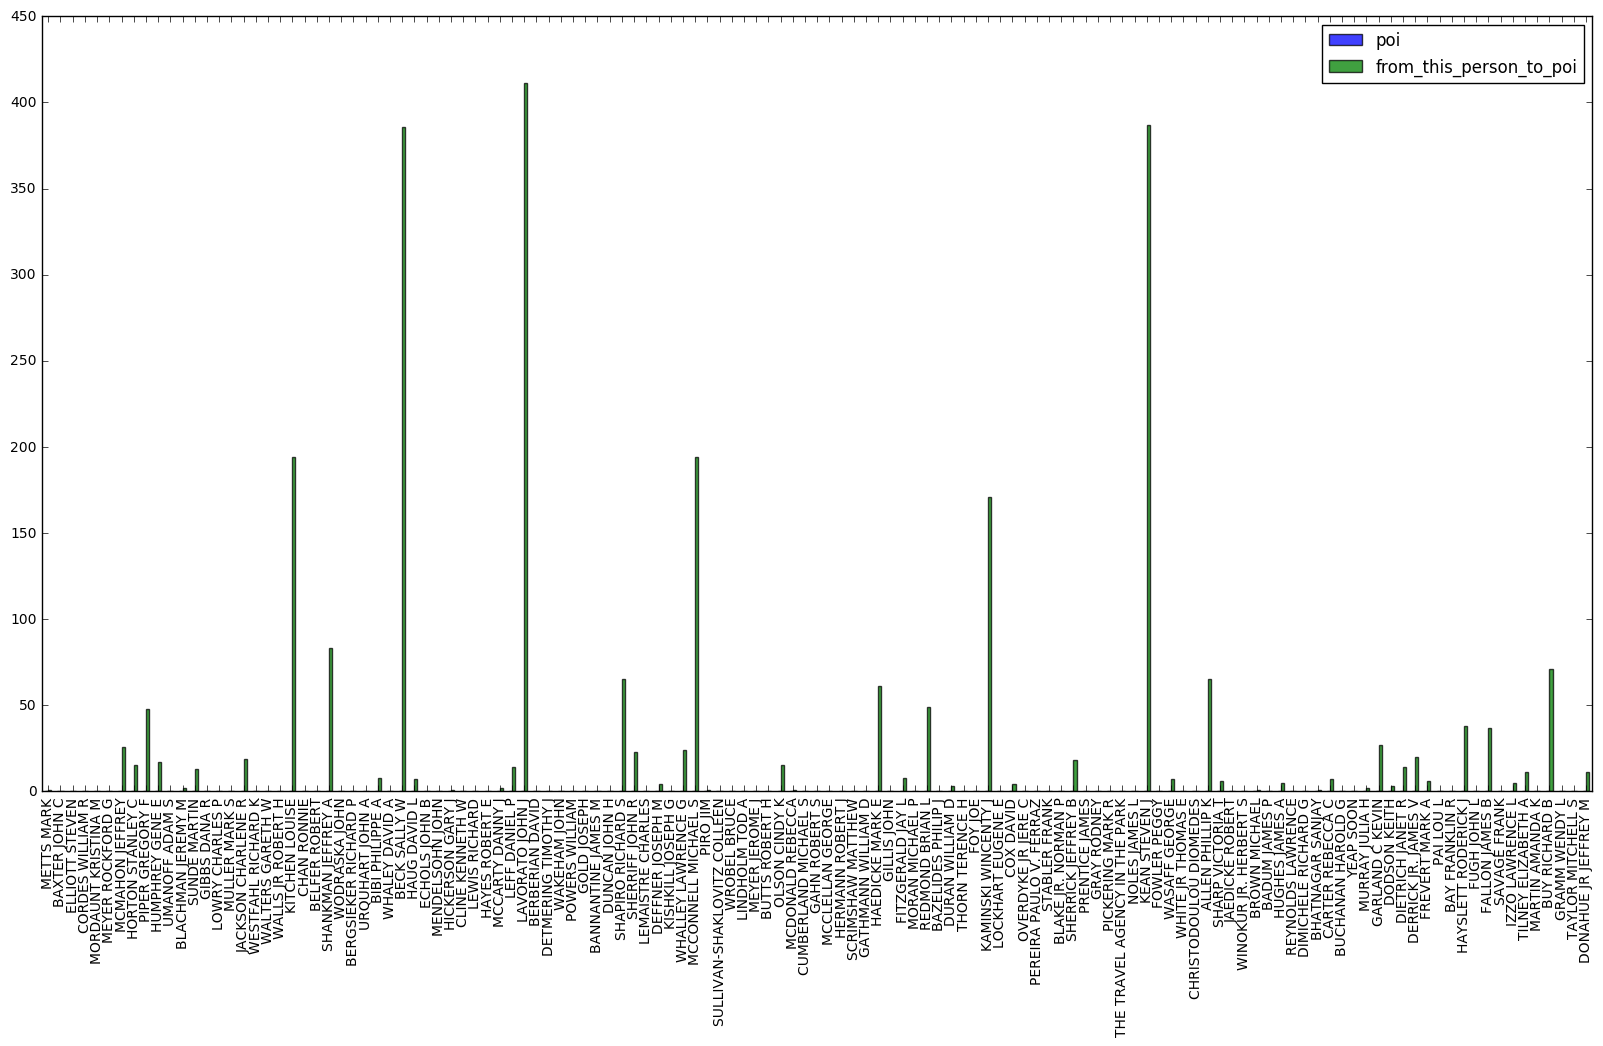

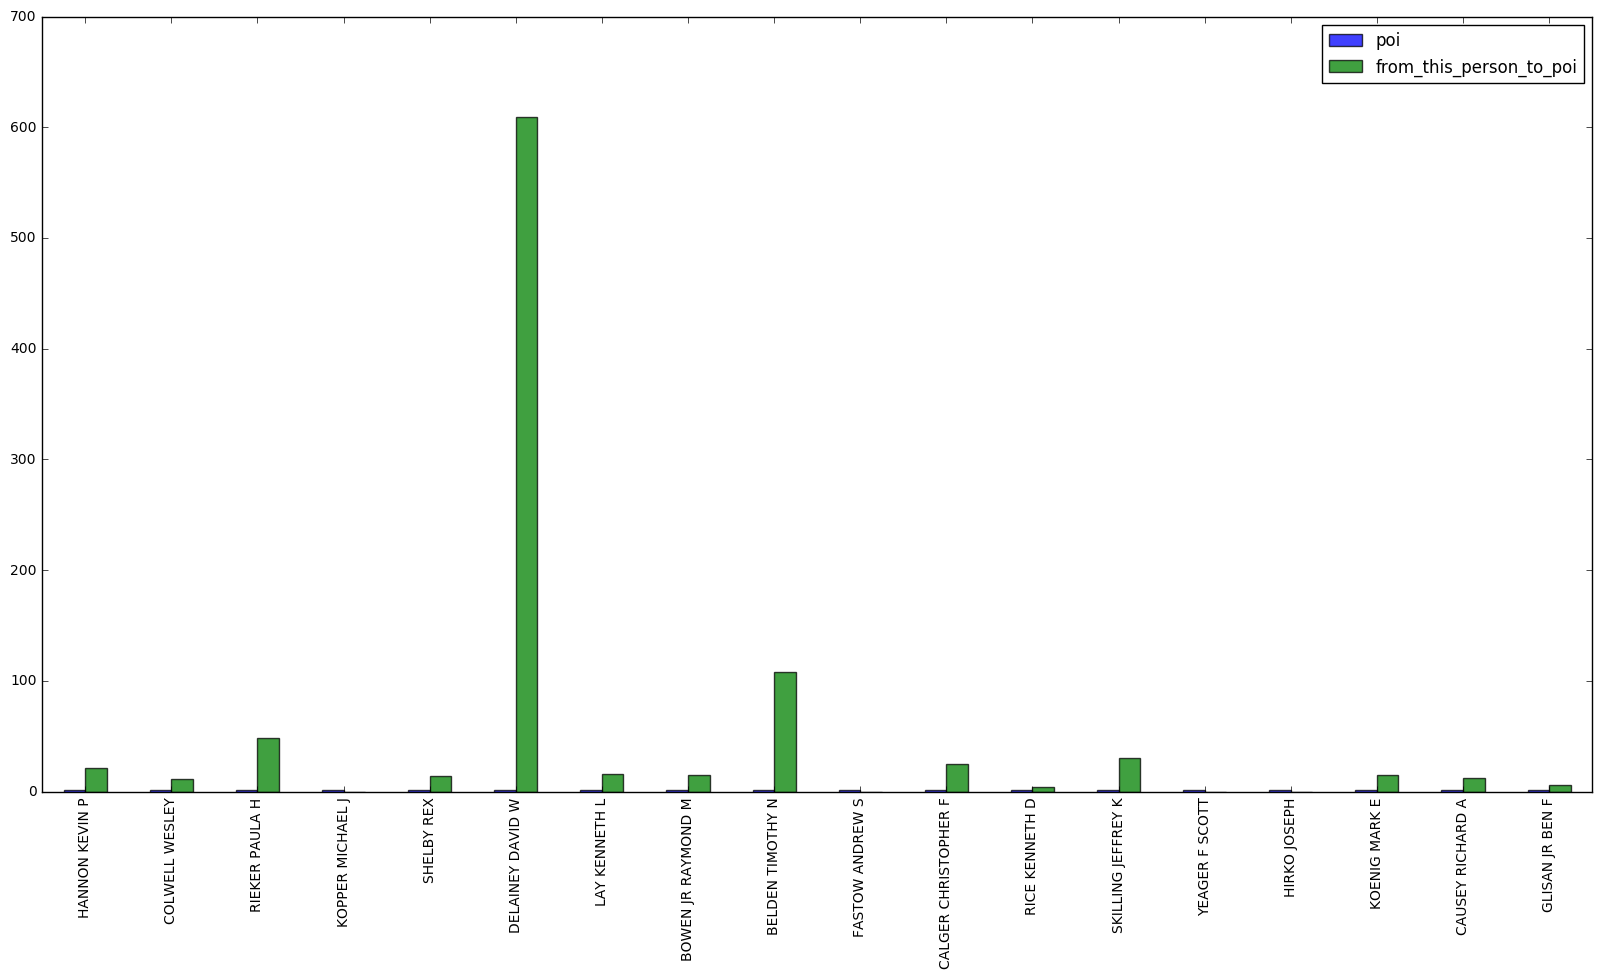


loan_advances


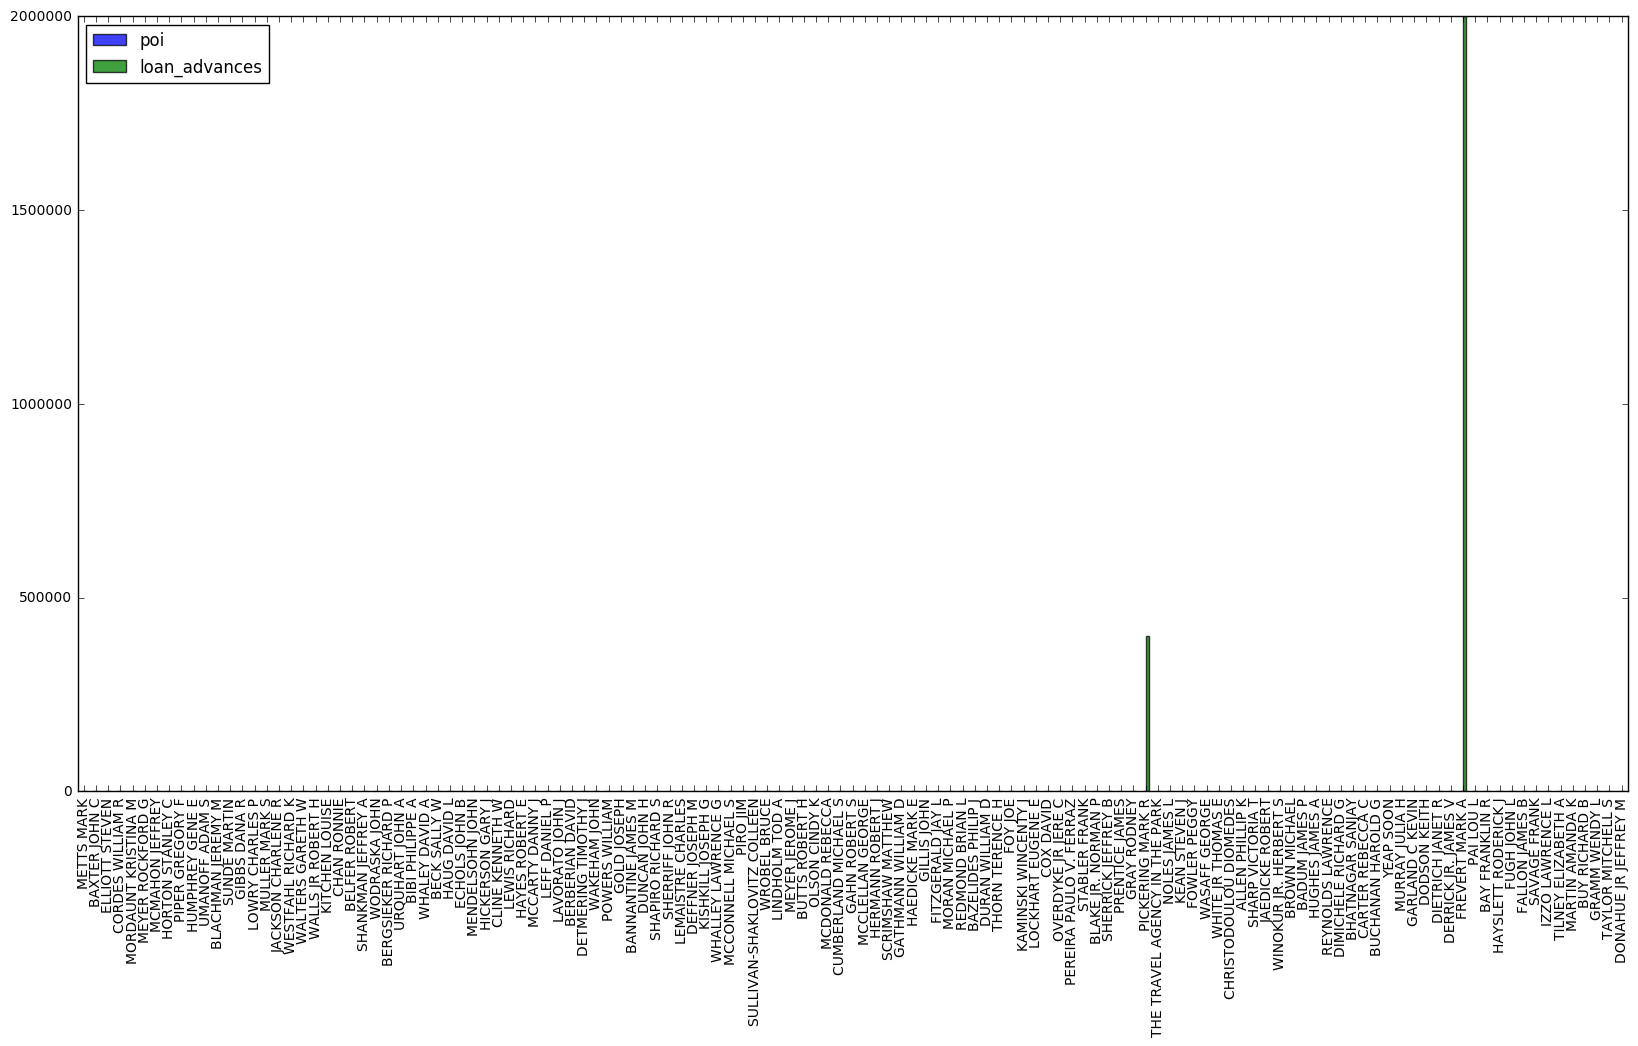

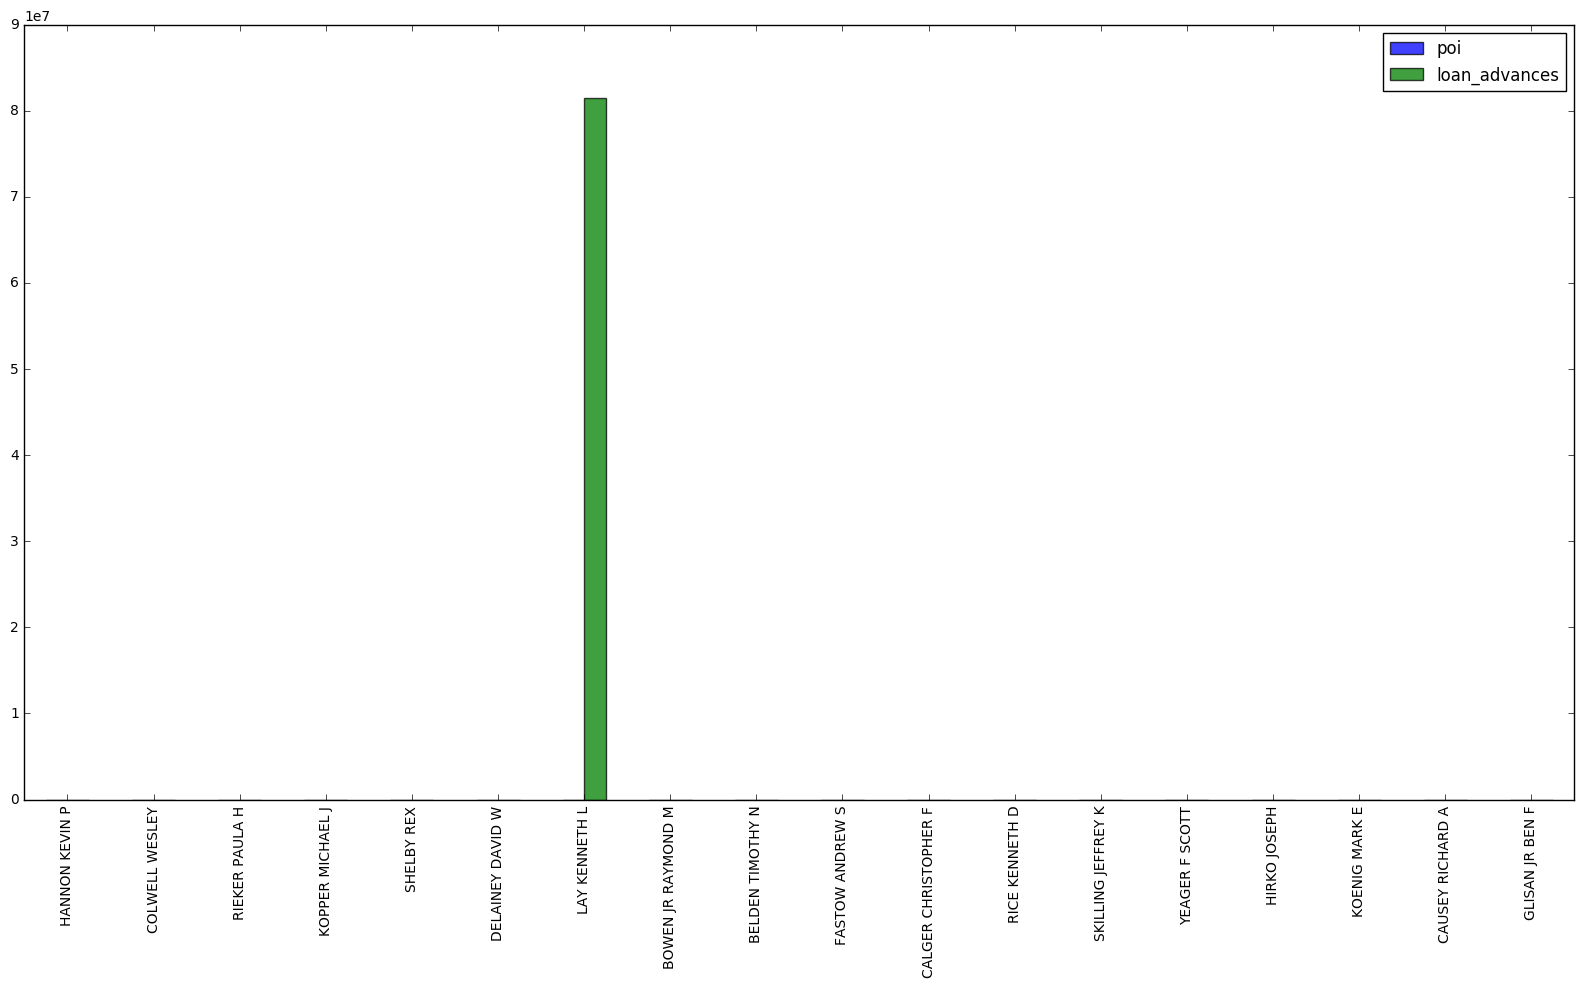


long_term_incentive


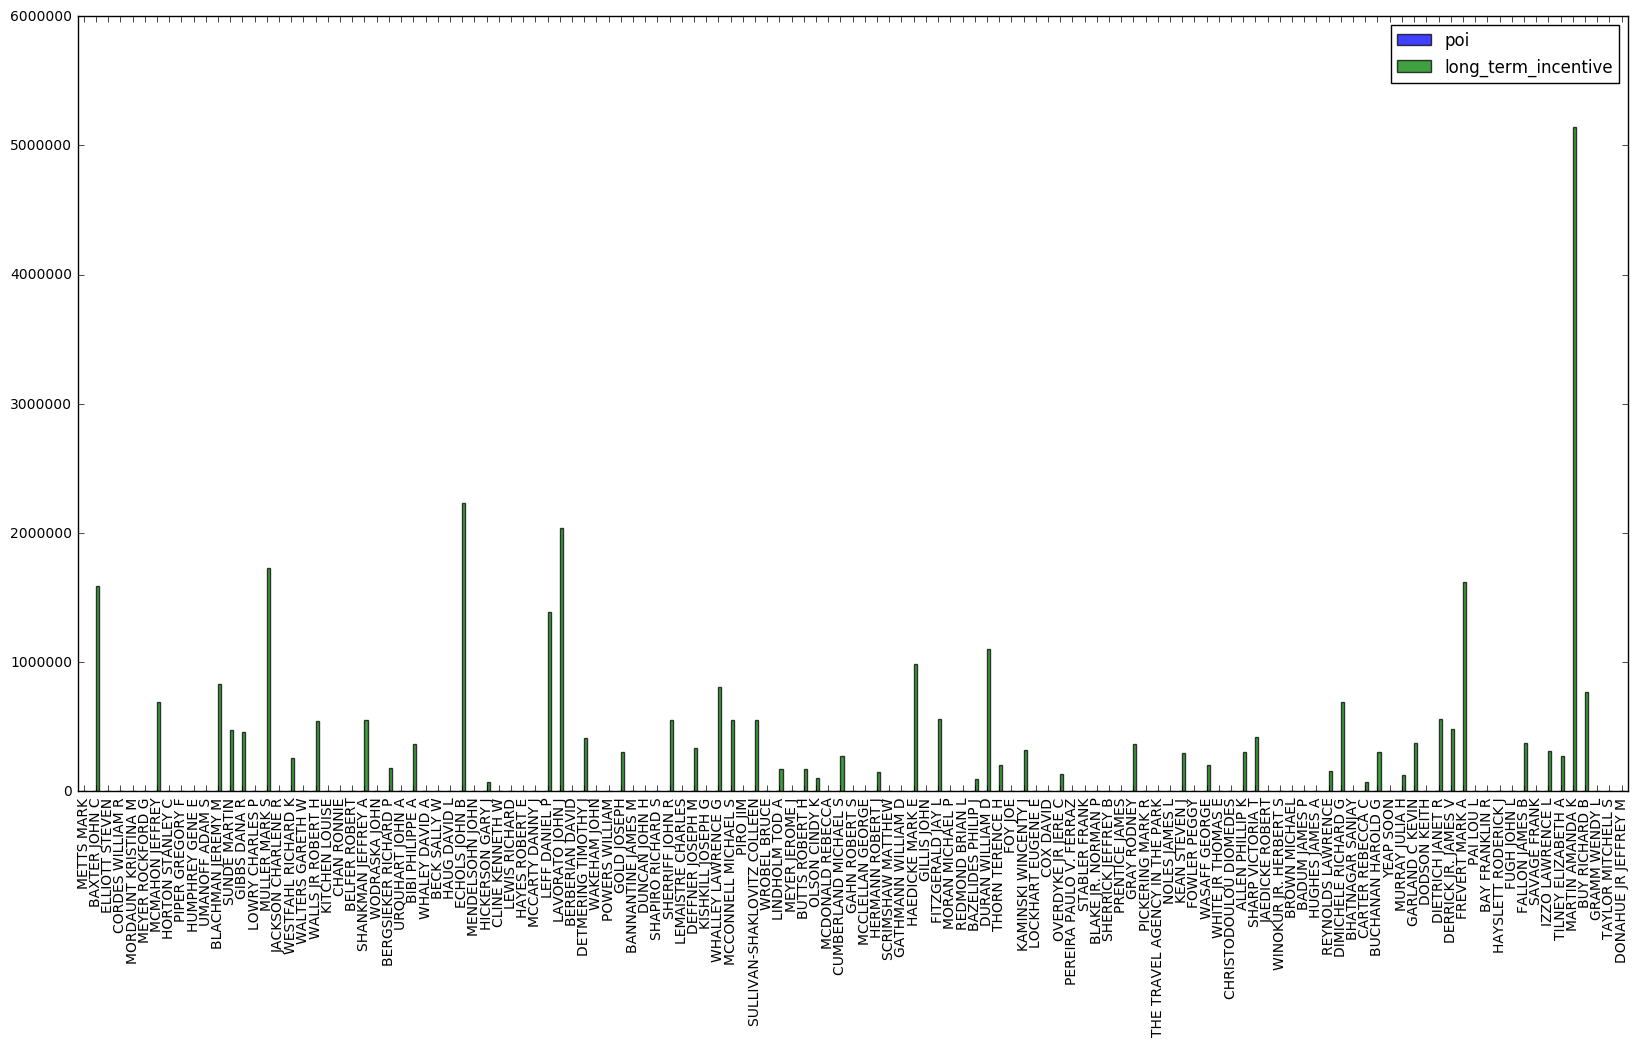

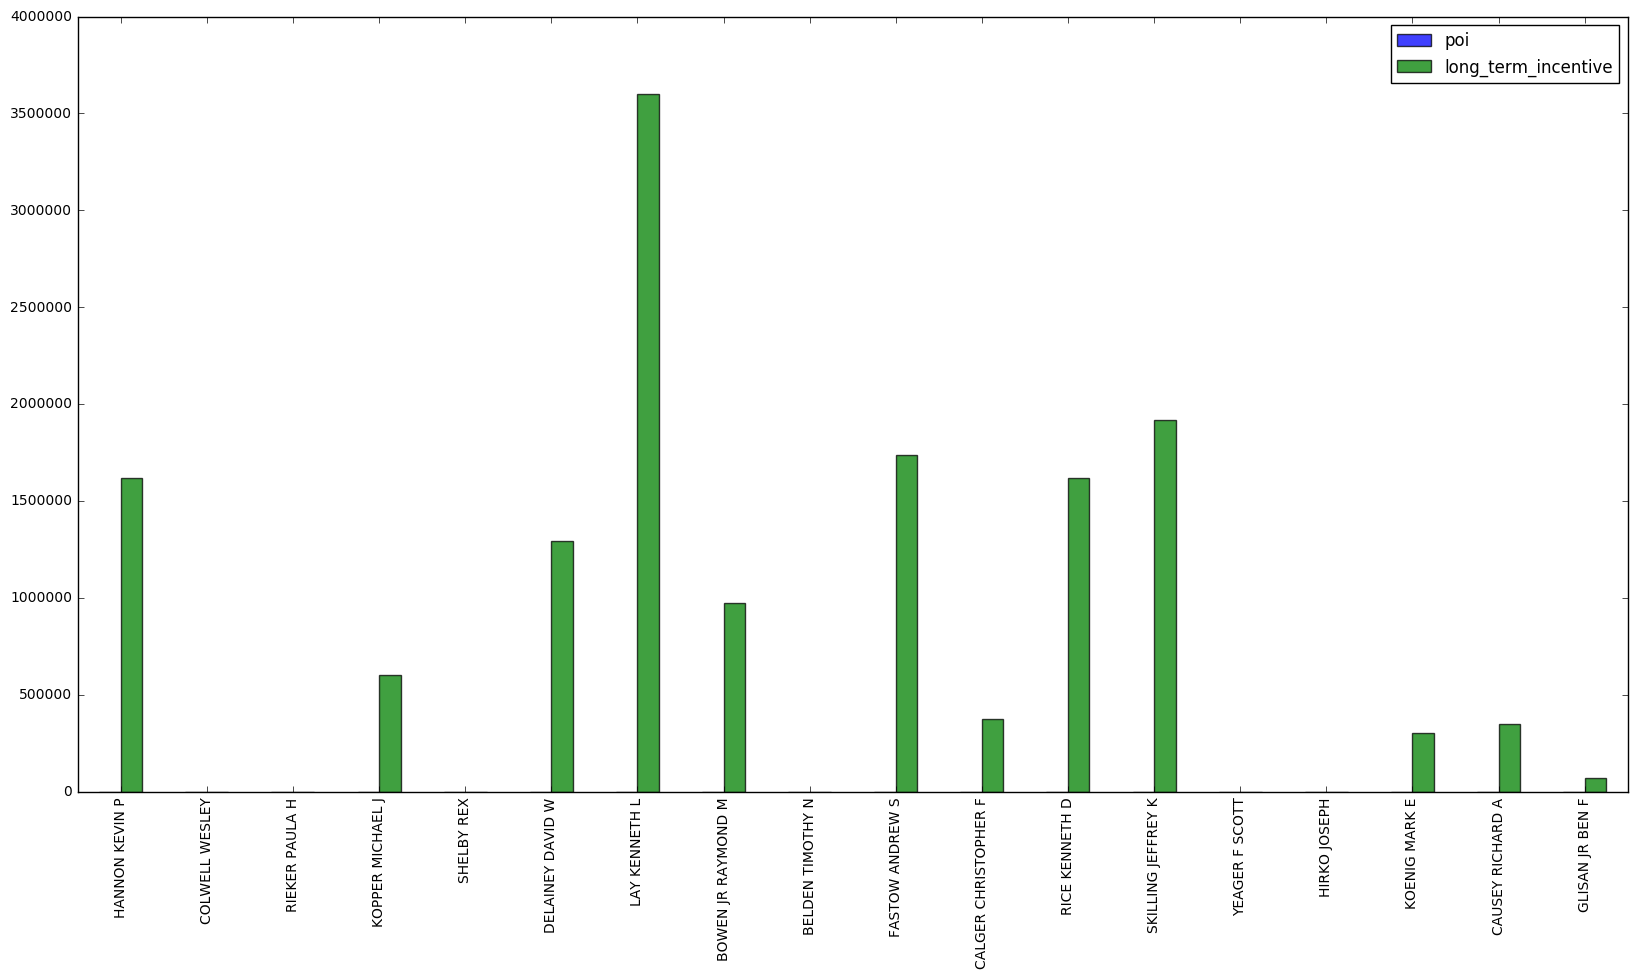


other


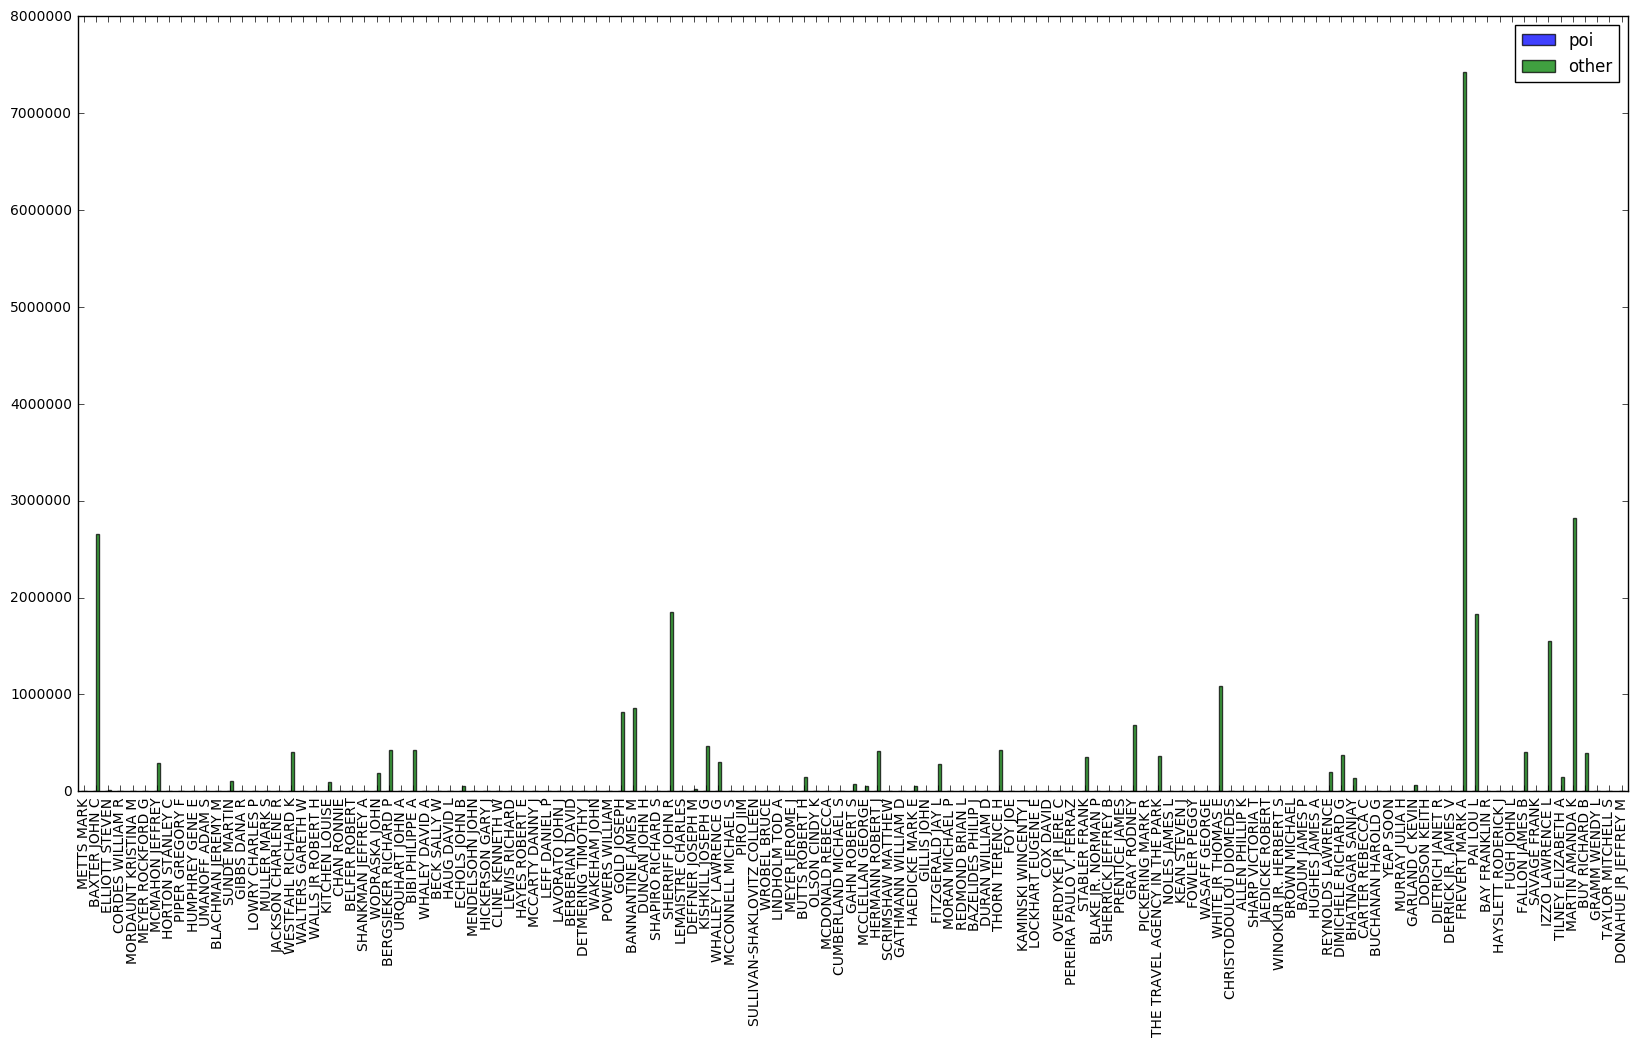

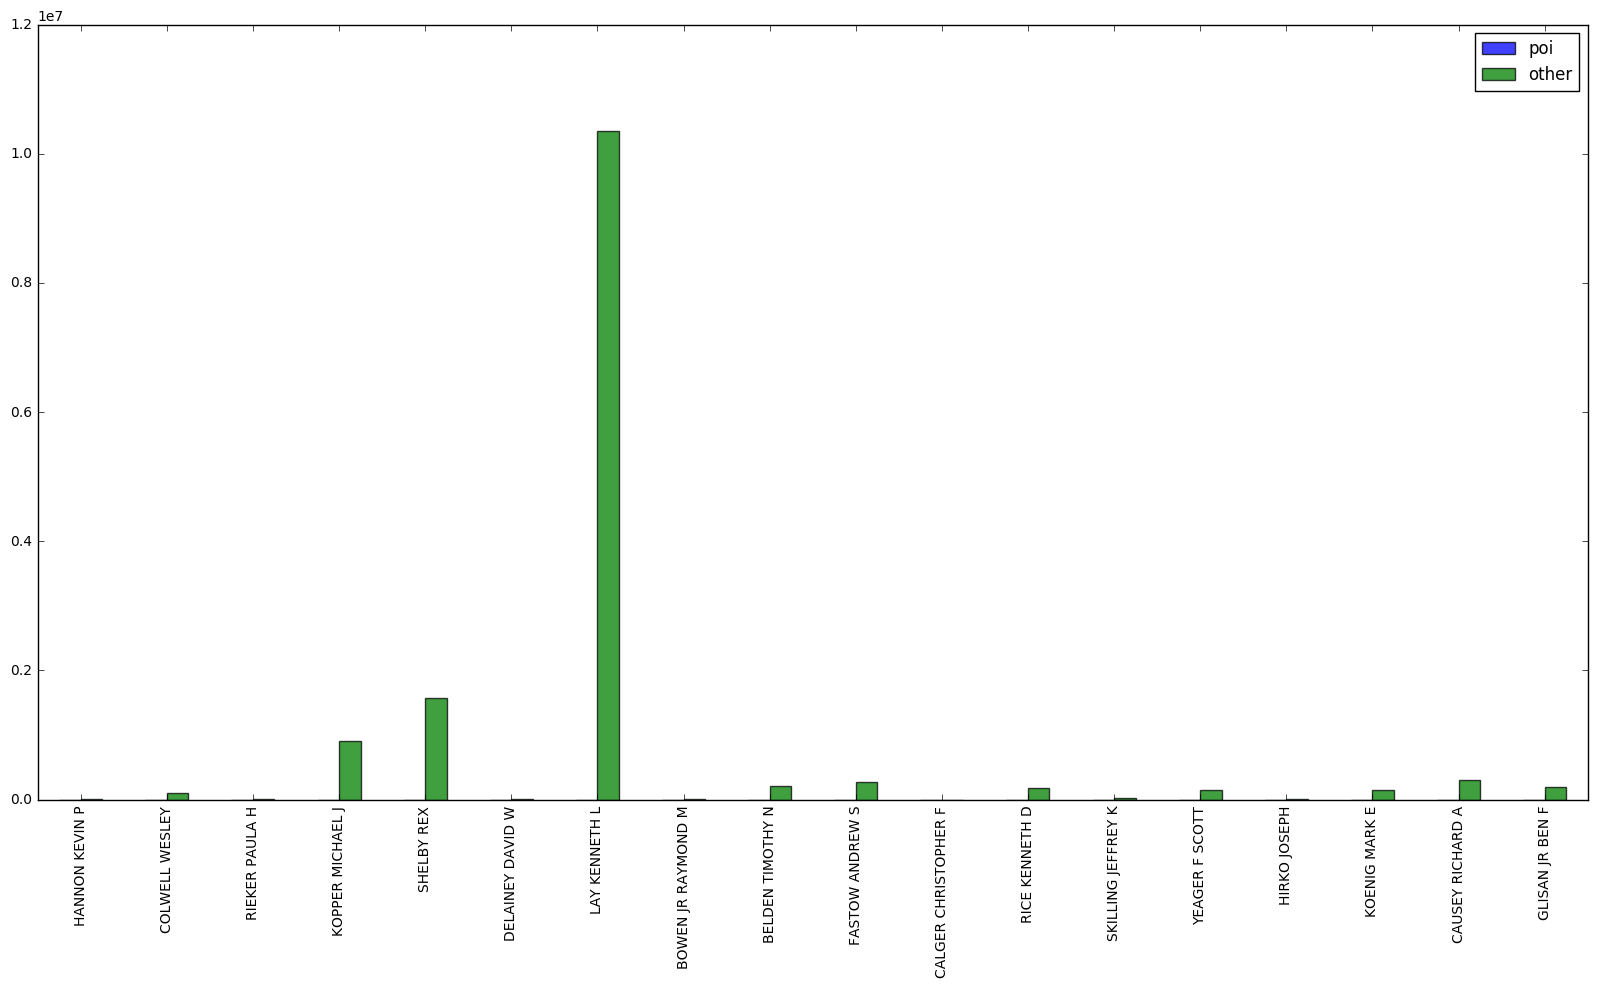


restricted_stock


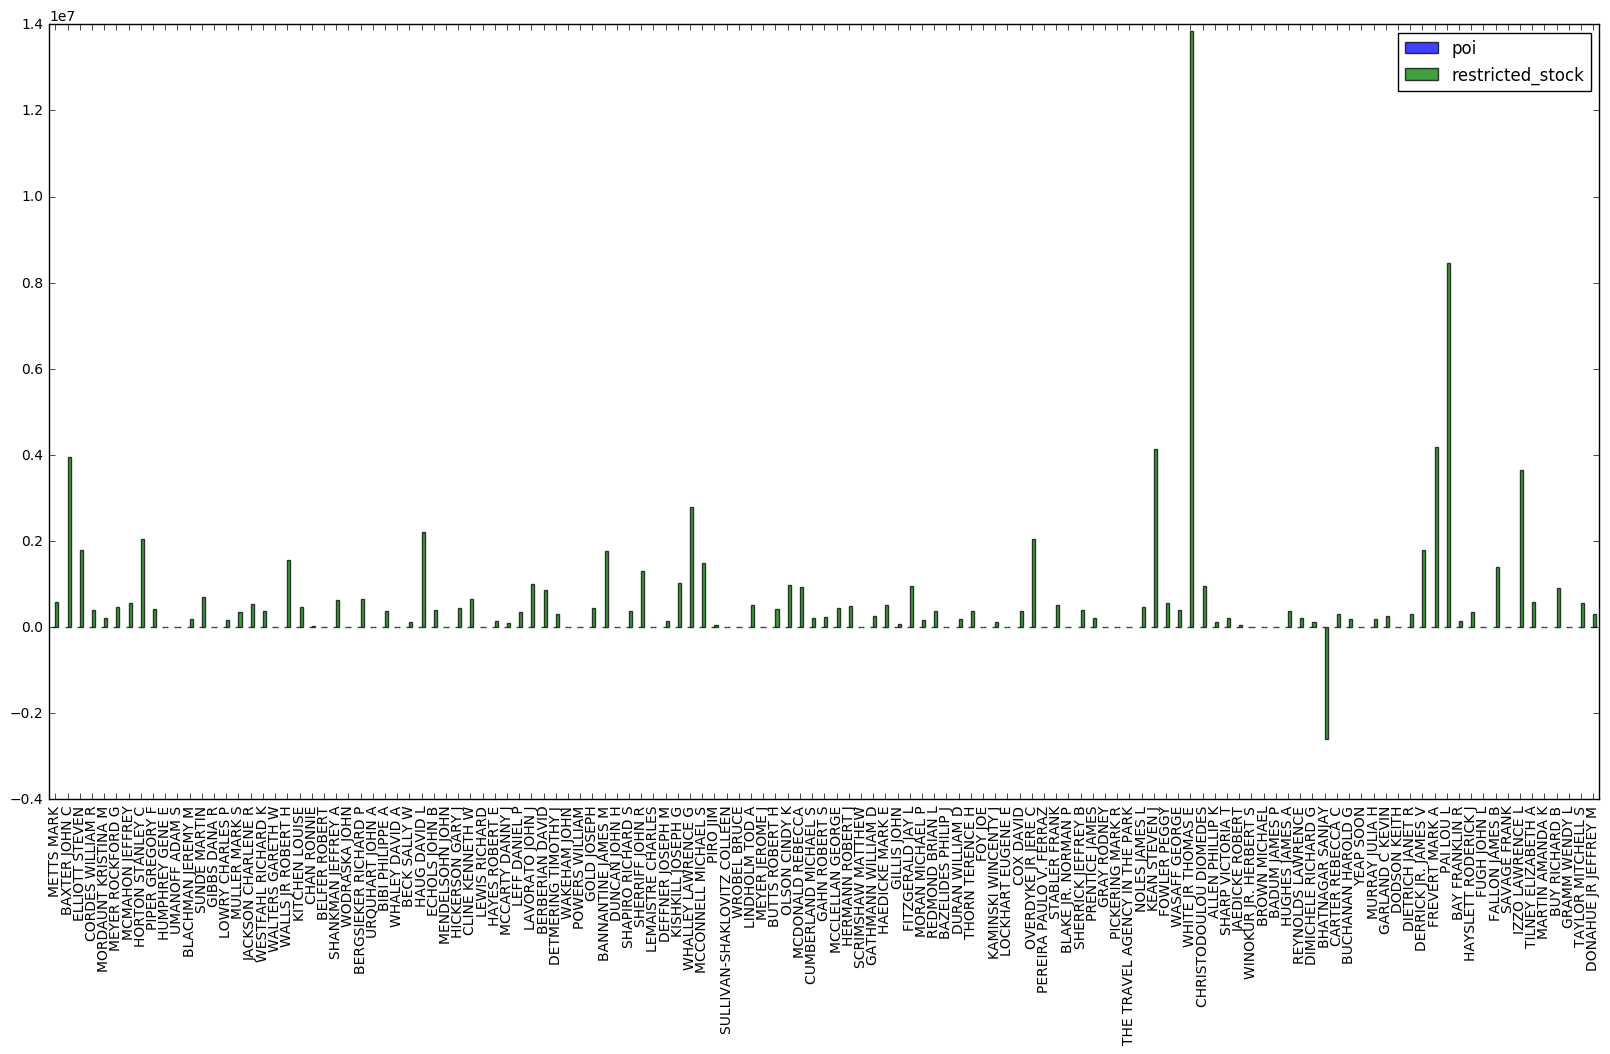

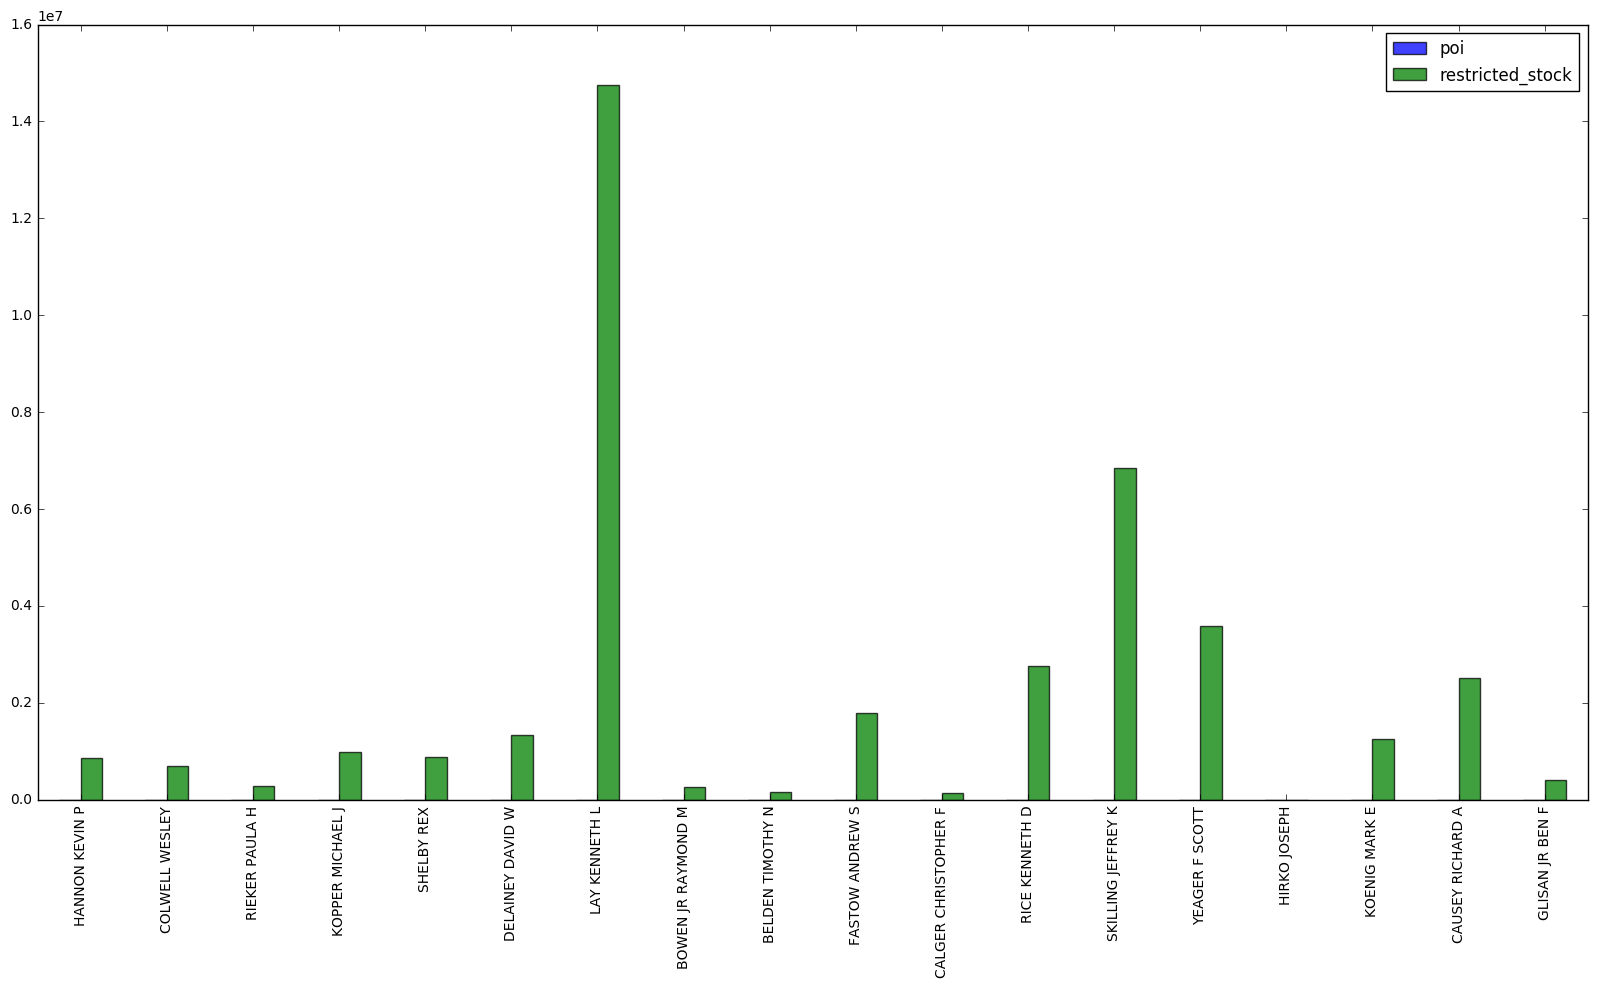


restricted_stock_deferred


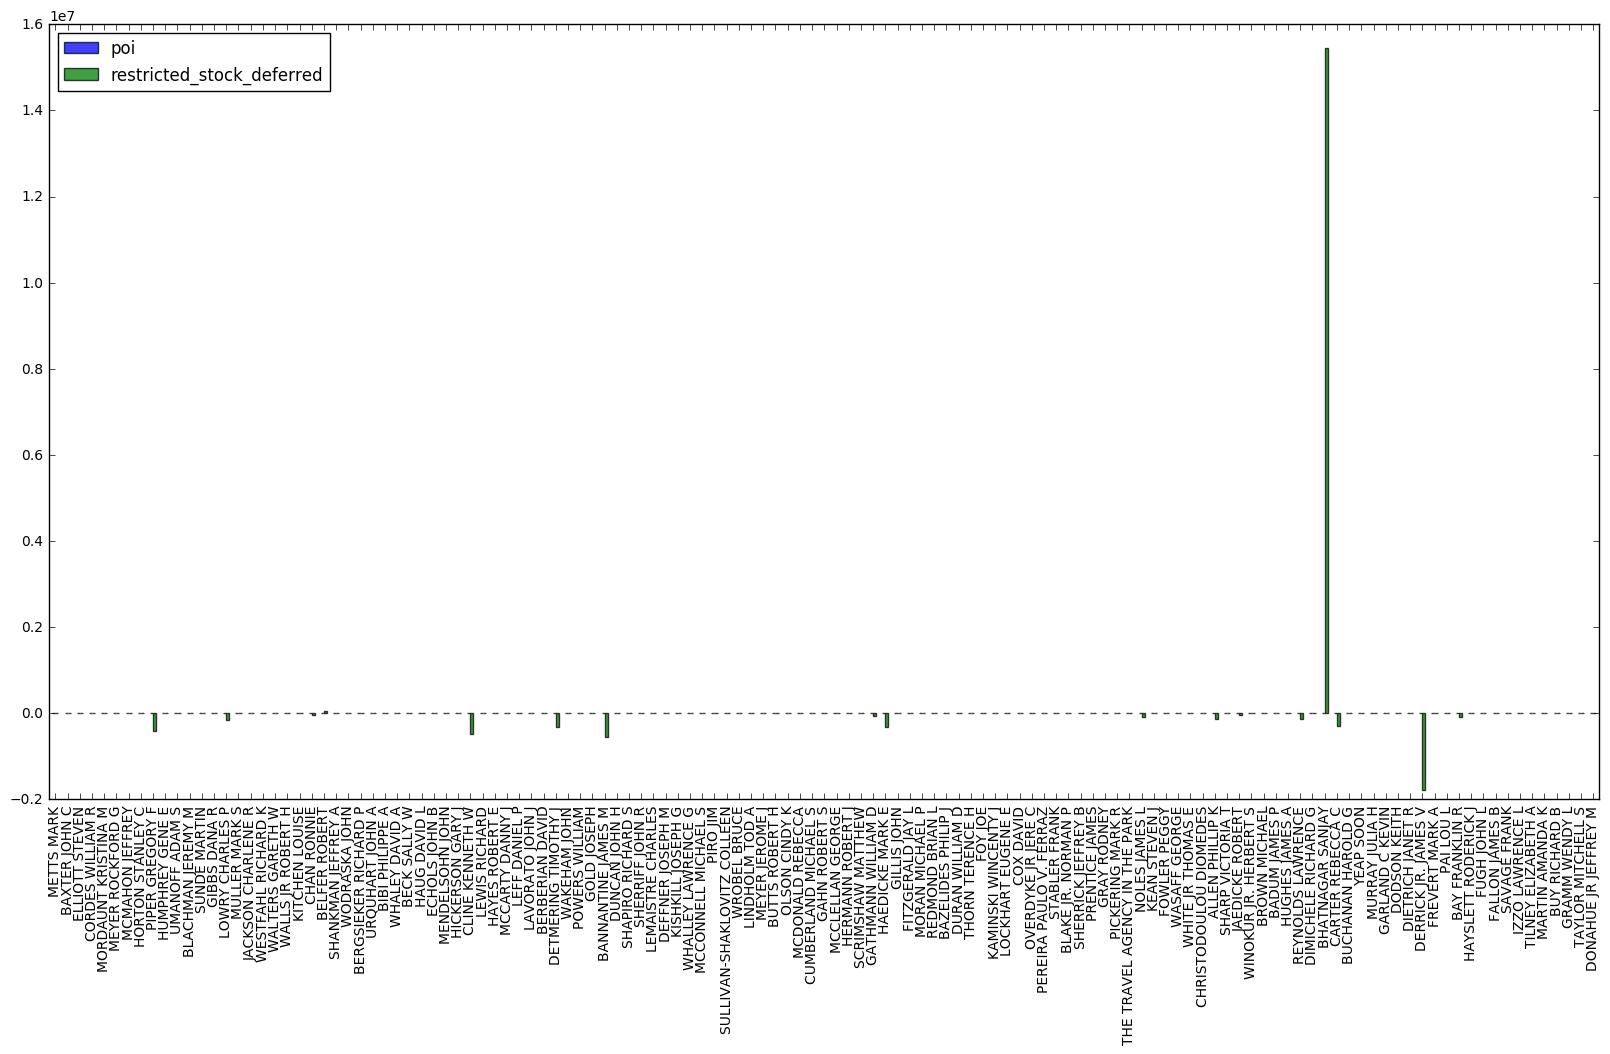

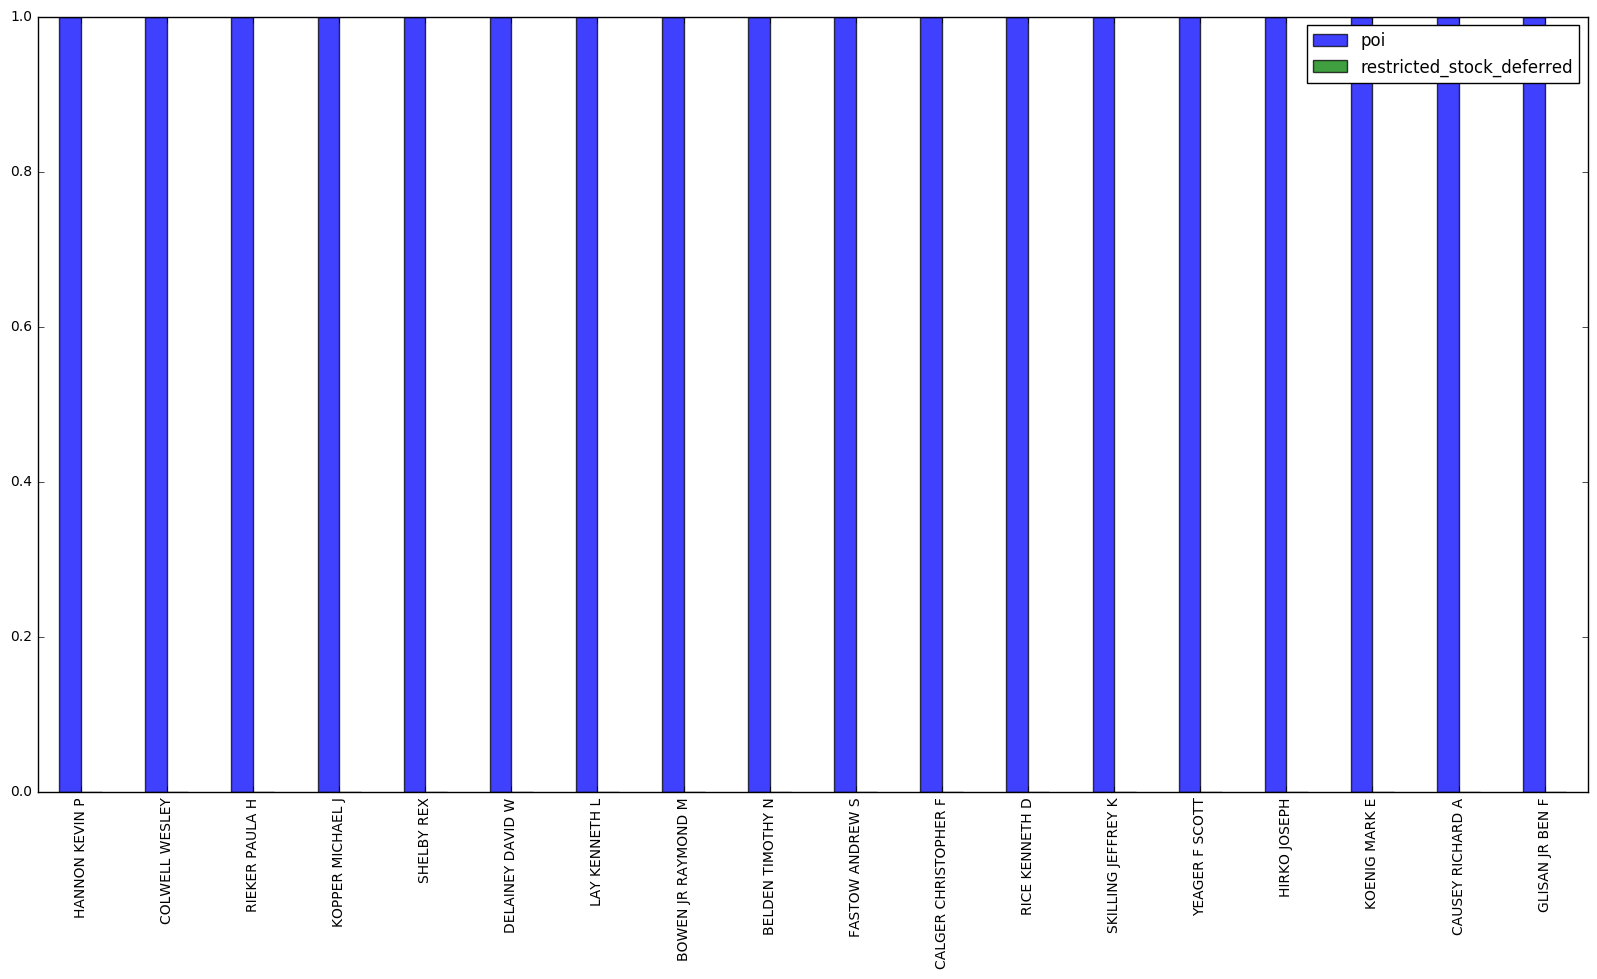


salary


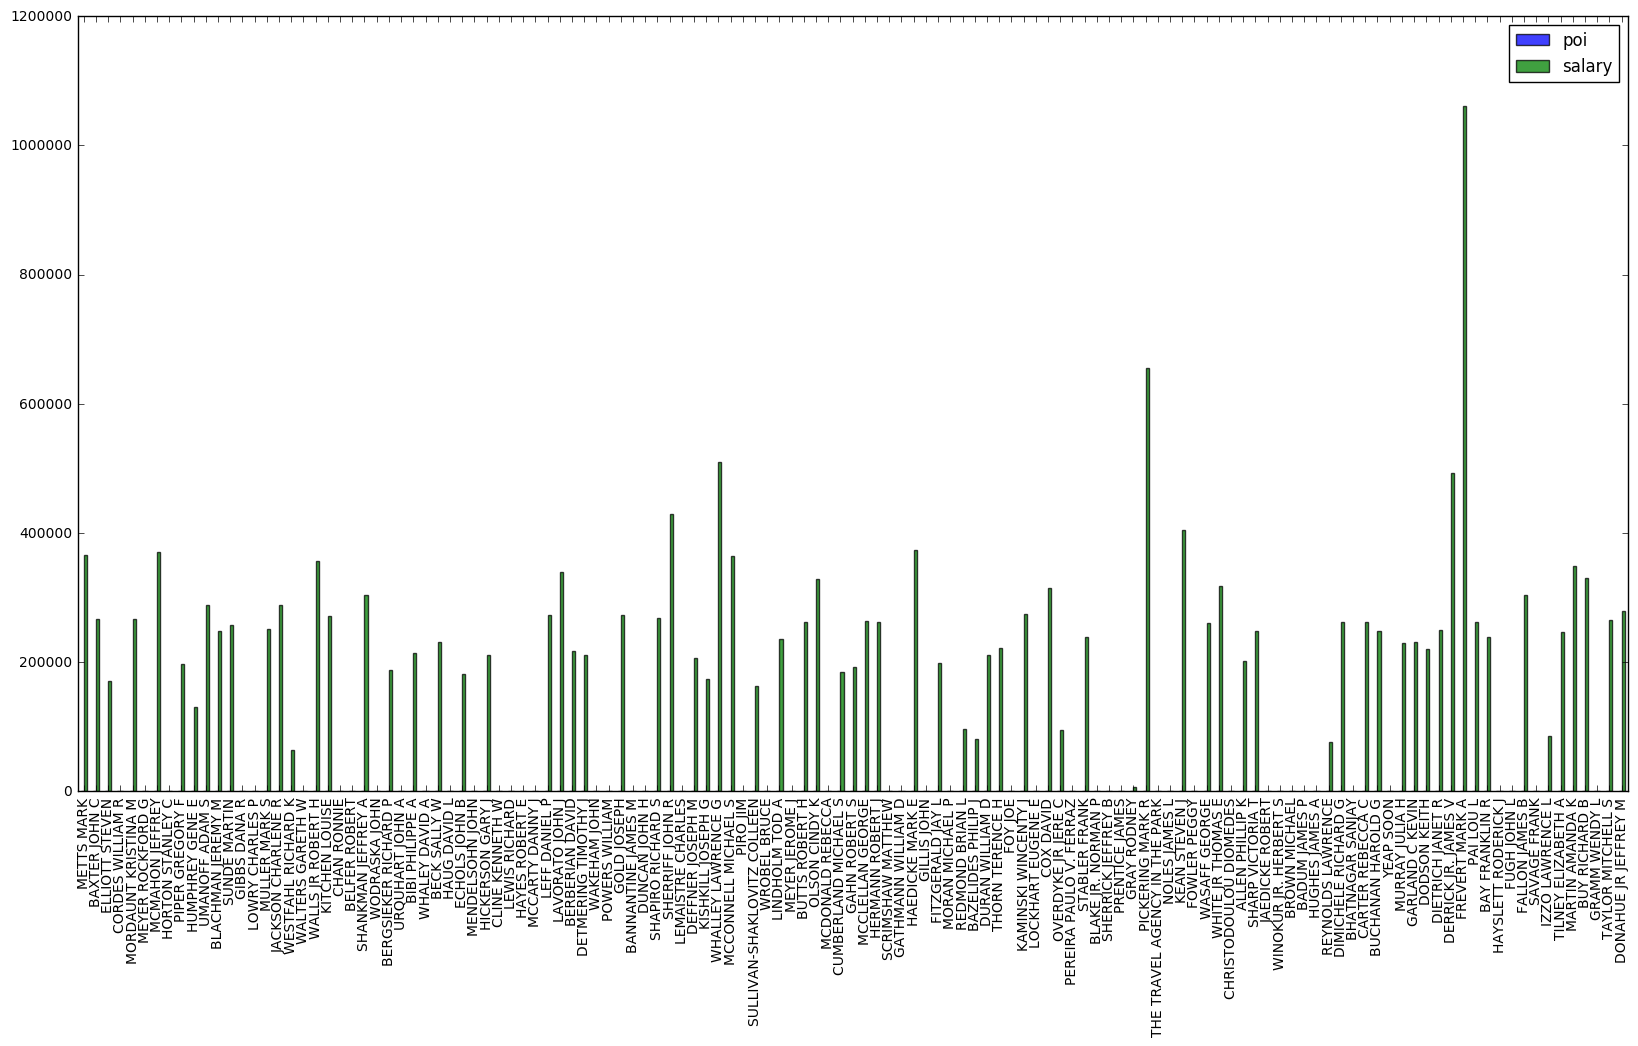

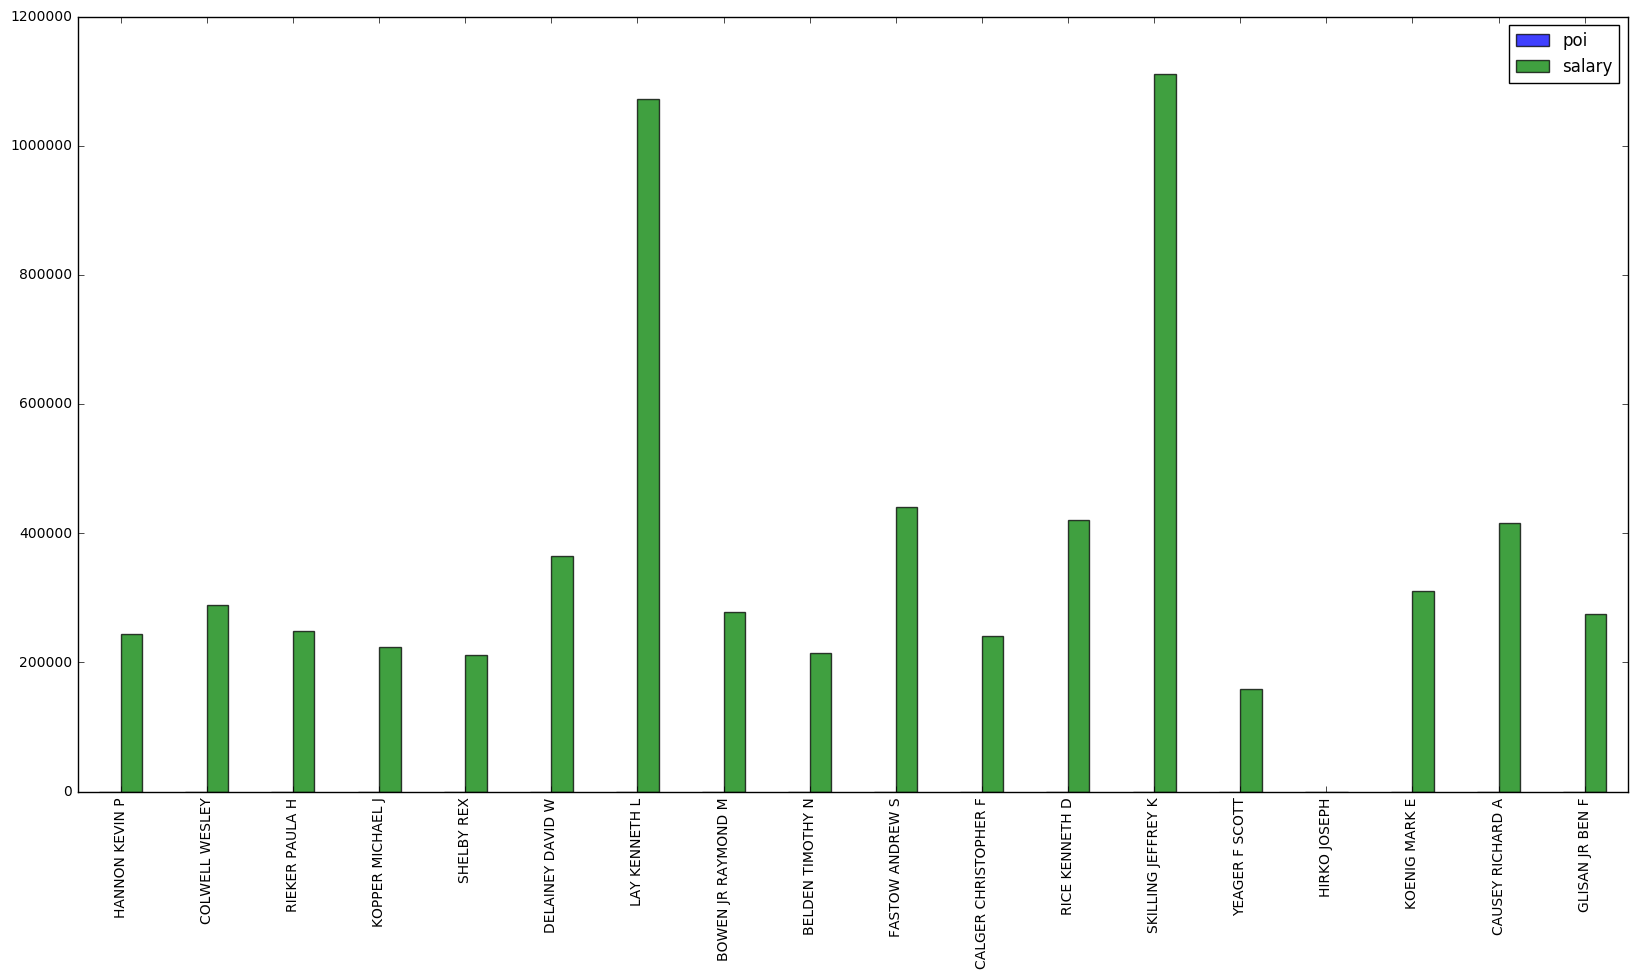


shared_receipt_with_poi


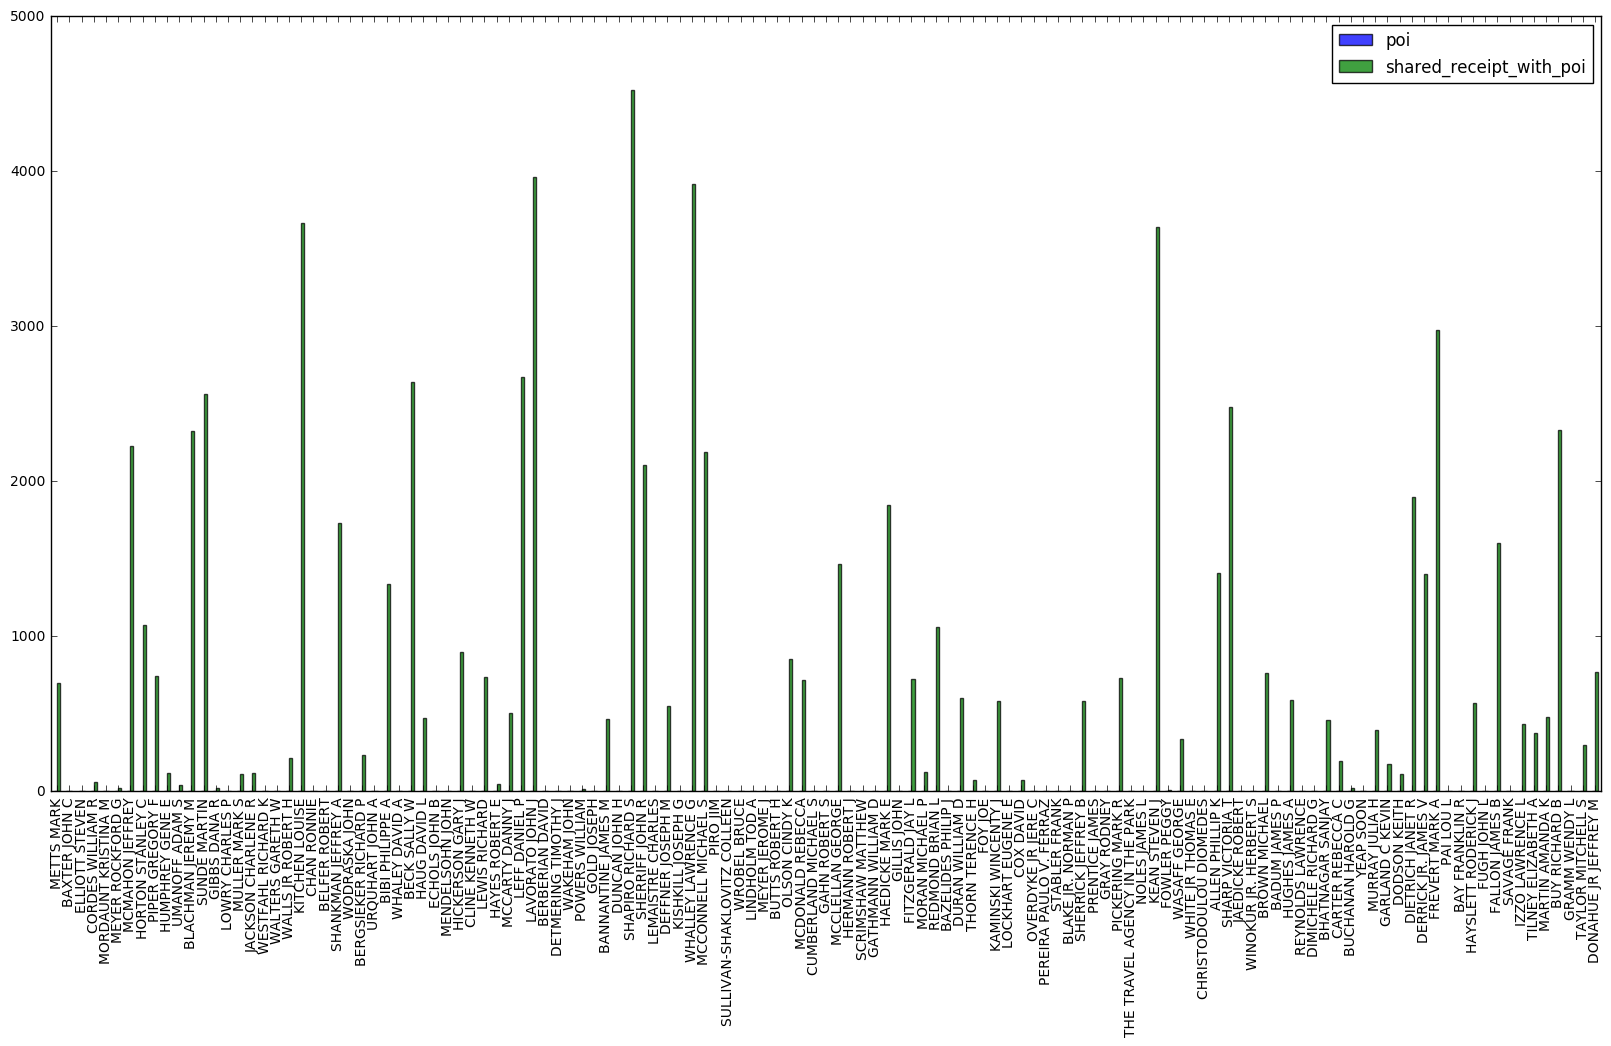

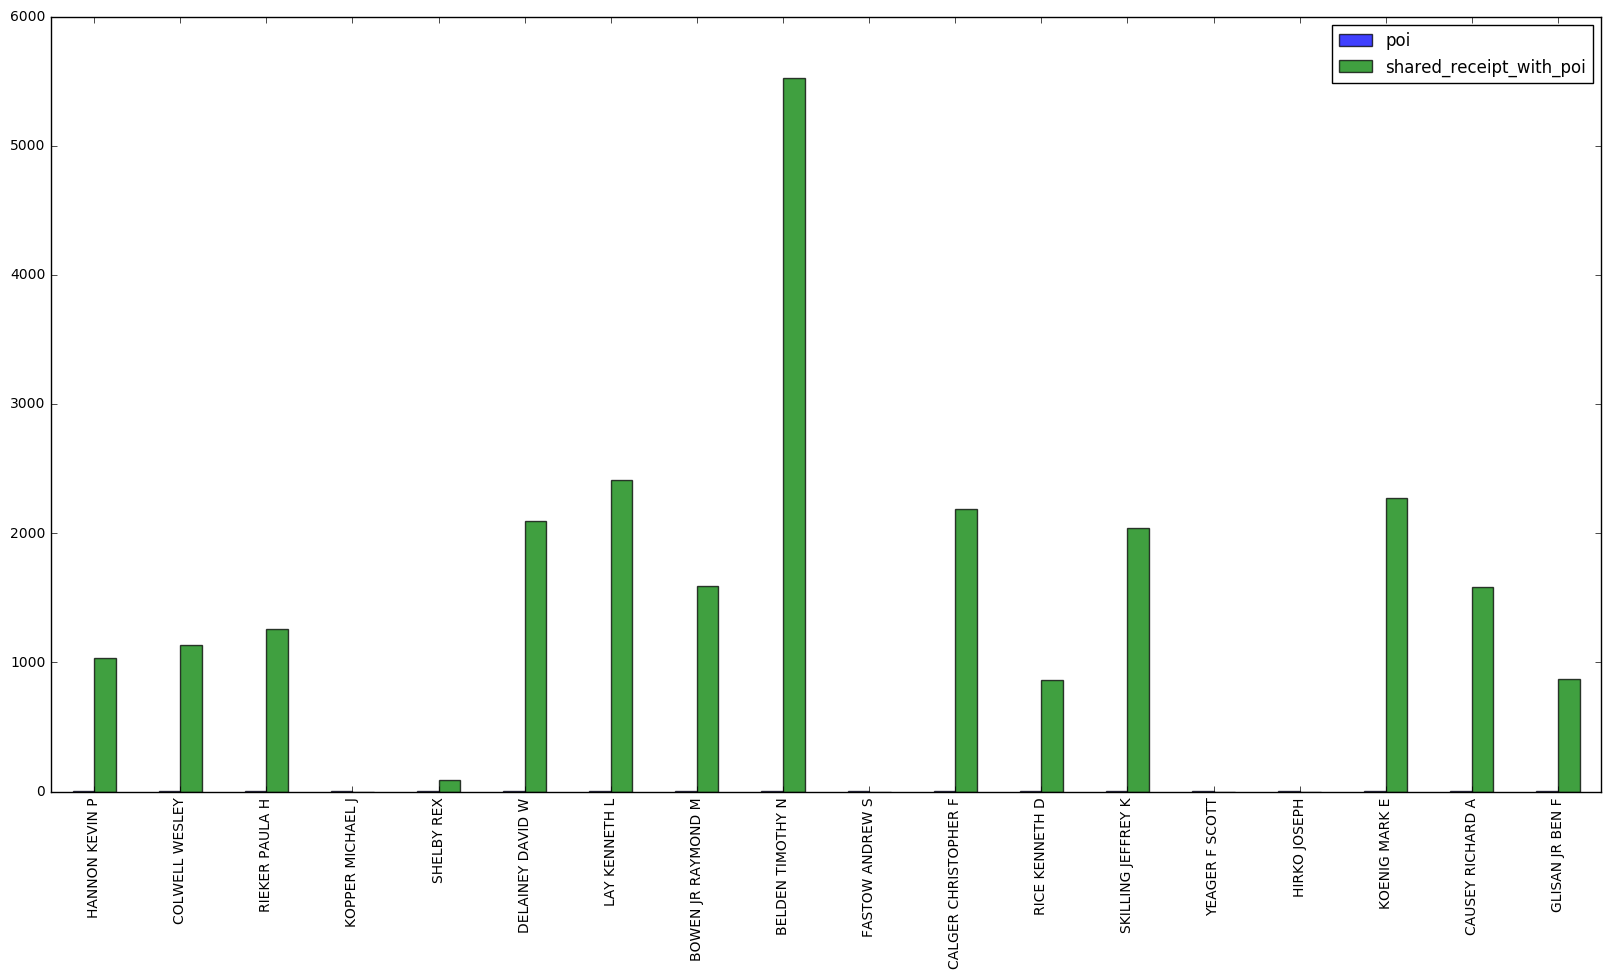


to_messages


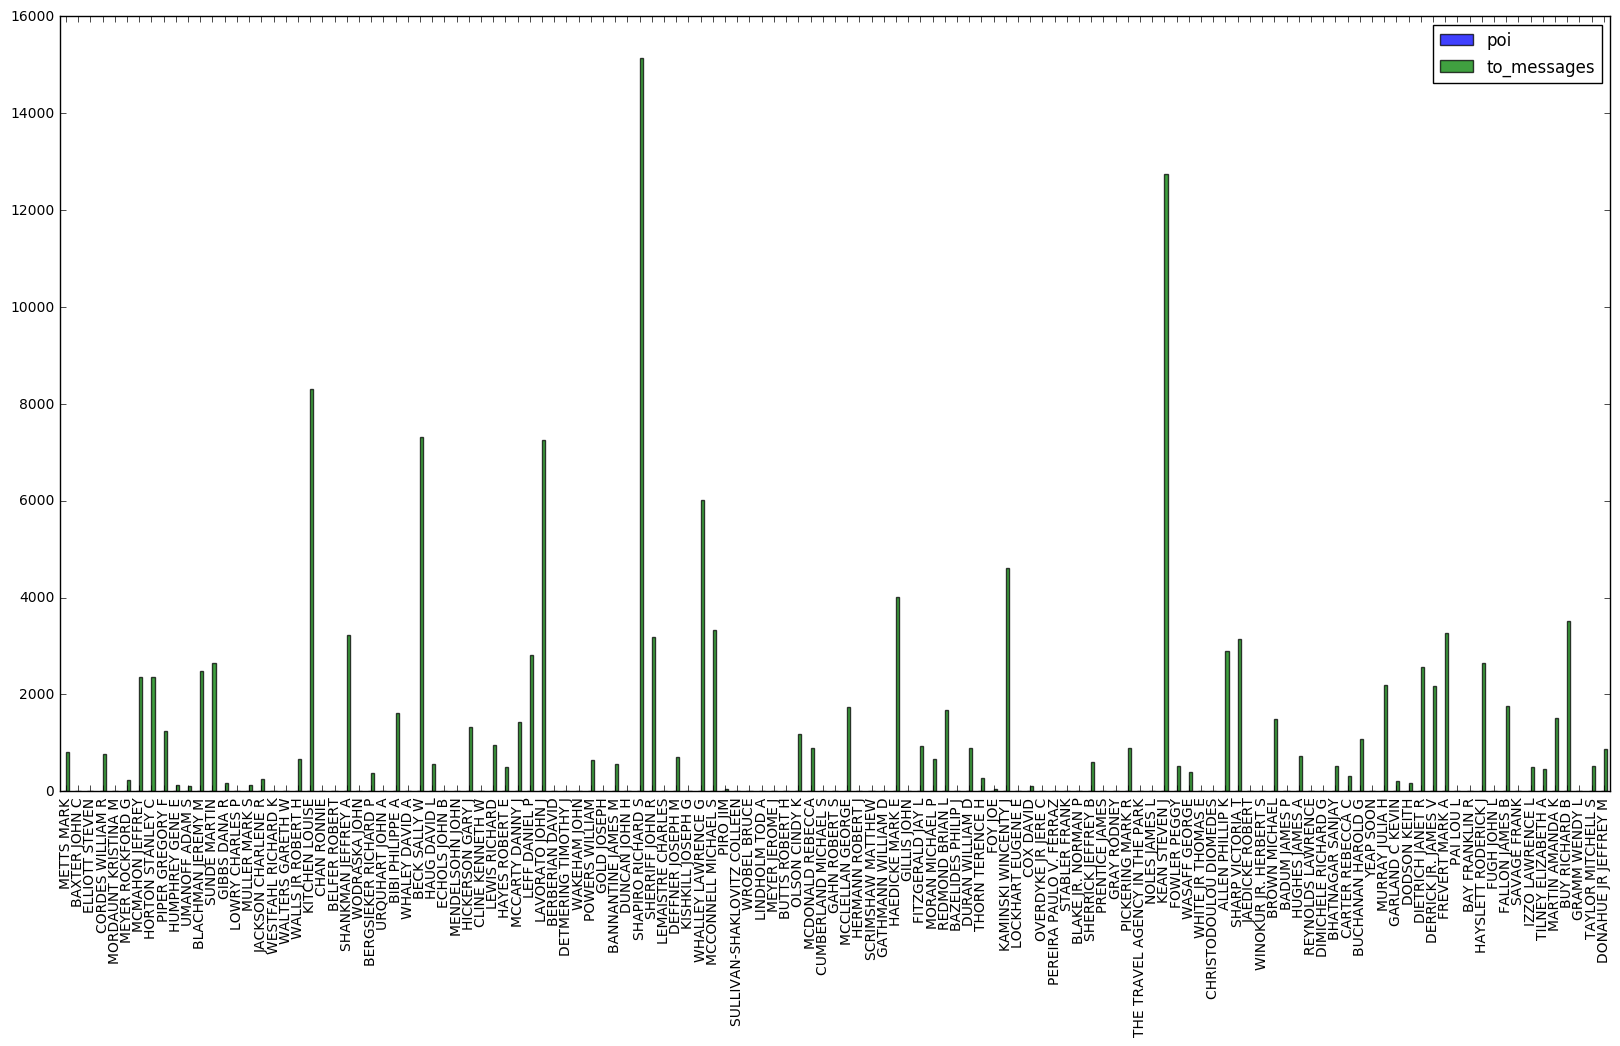

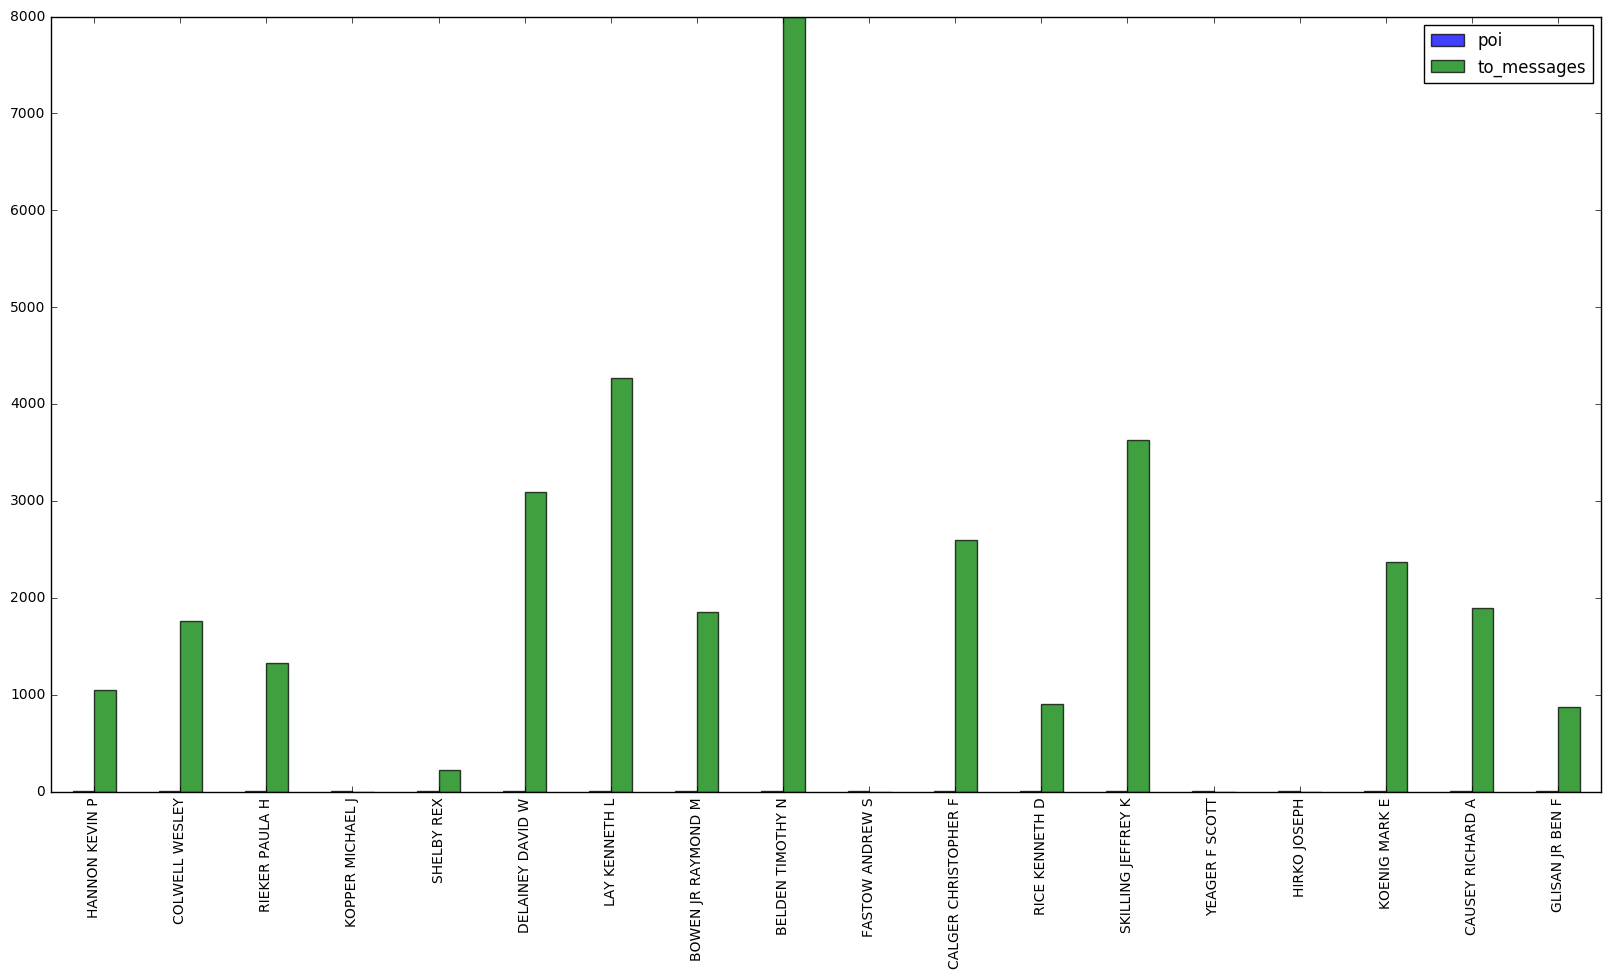


total_payments


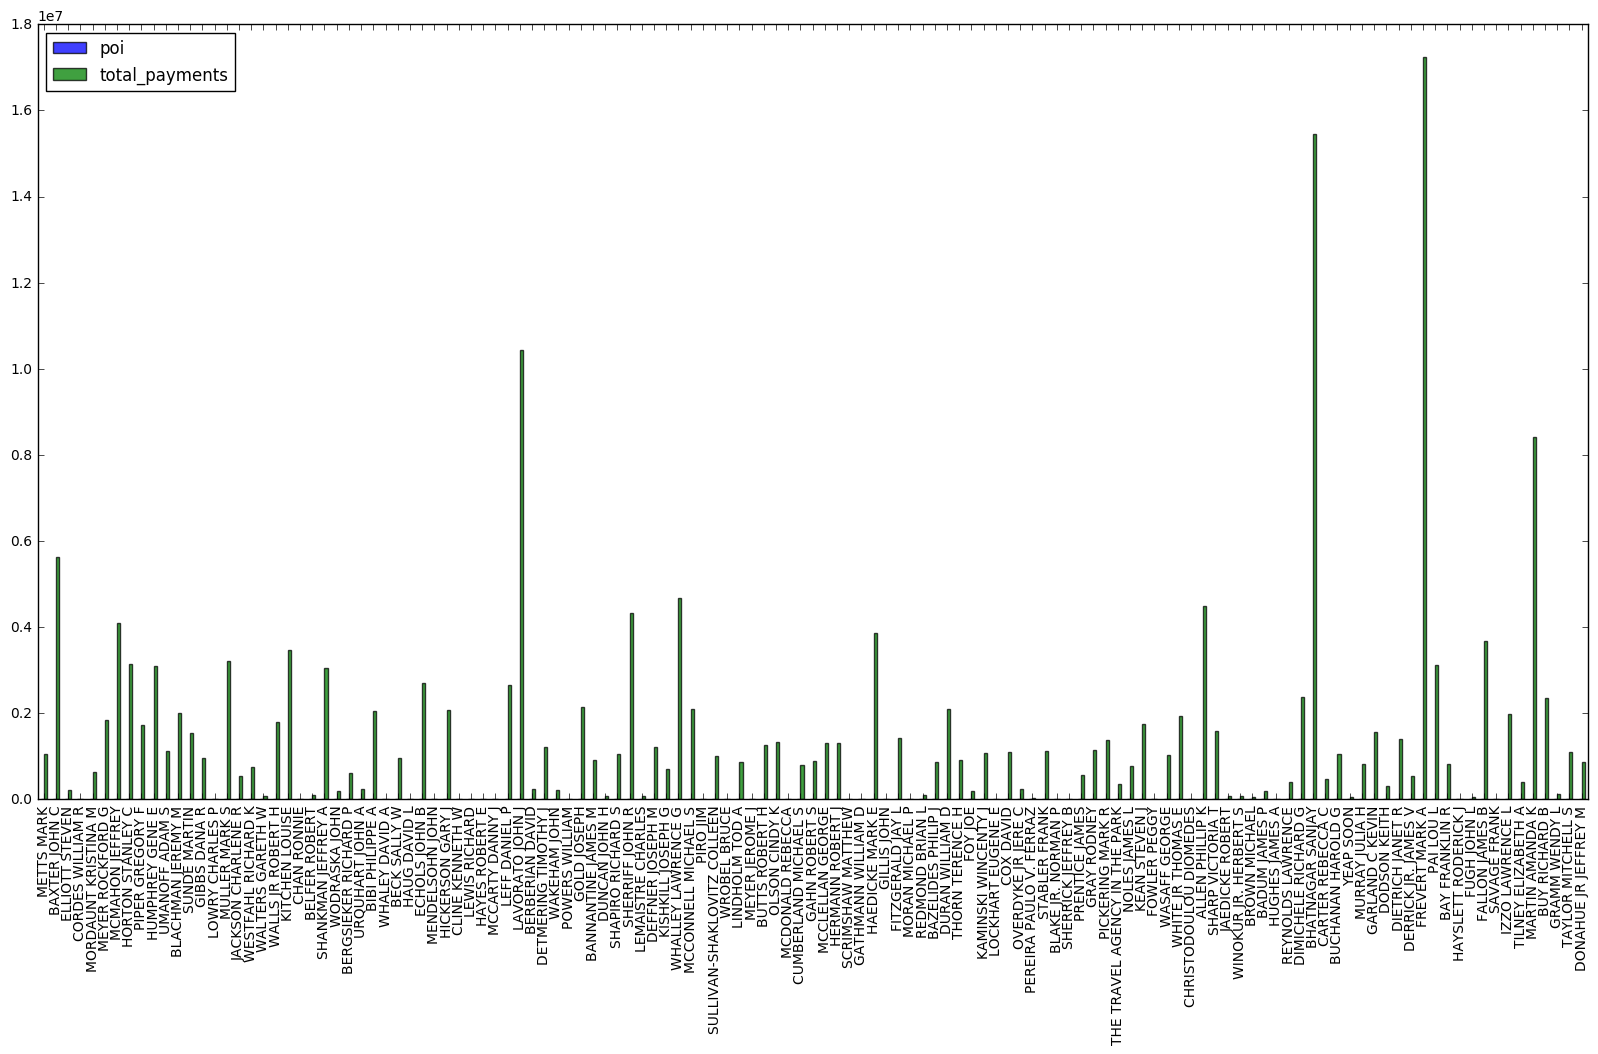

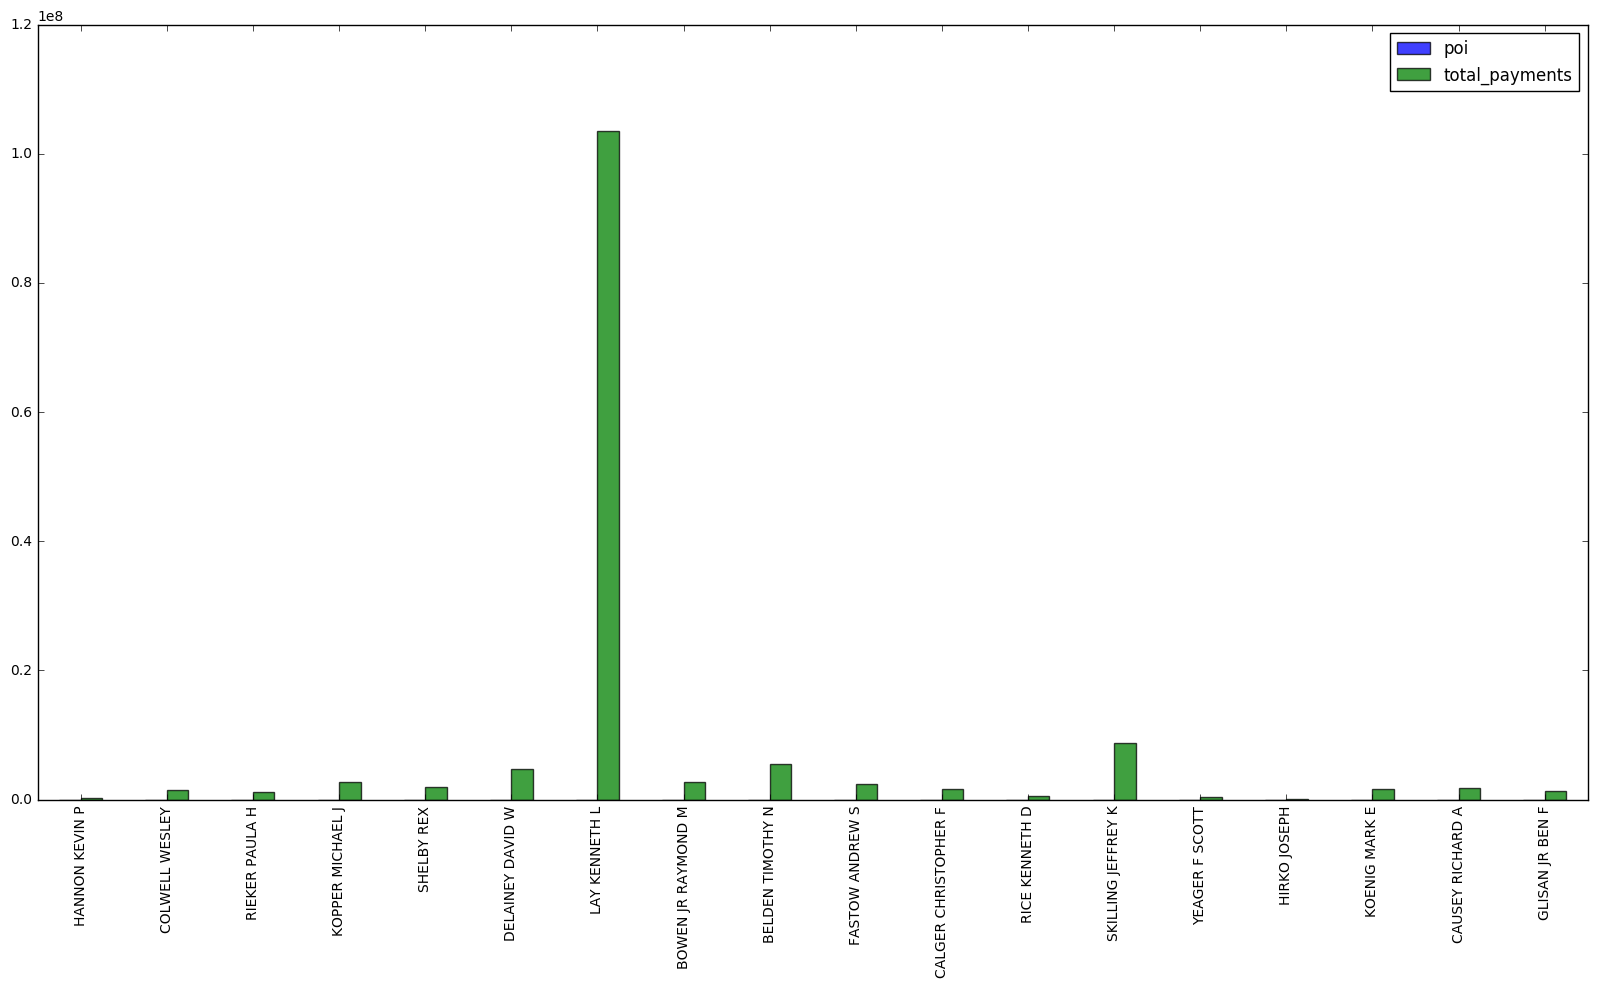


total_stock_value


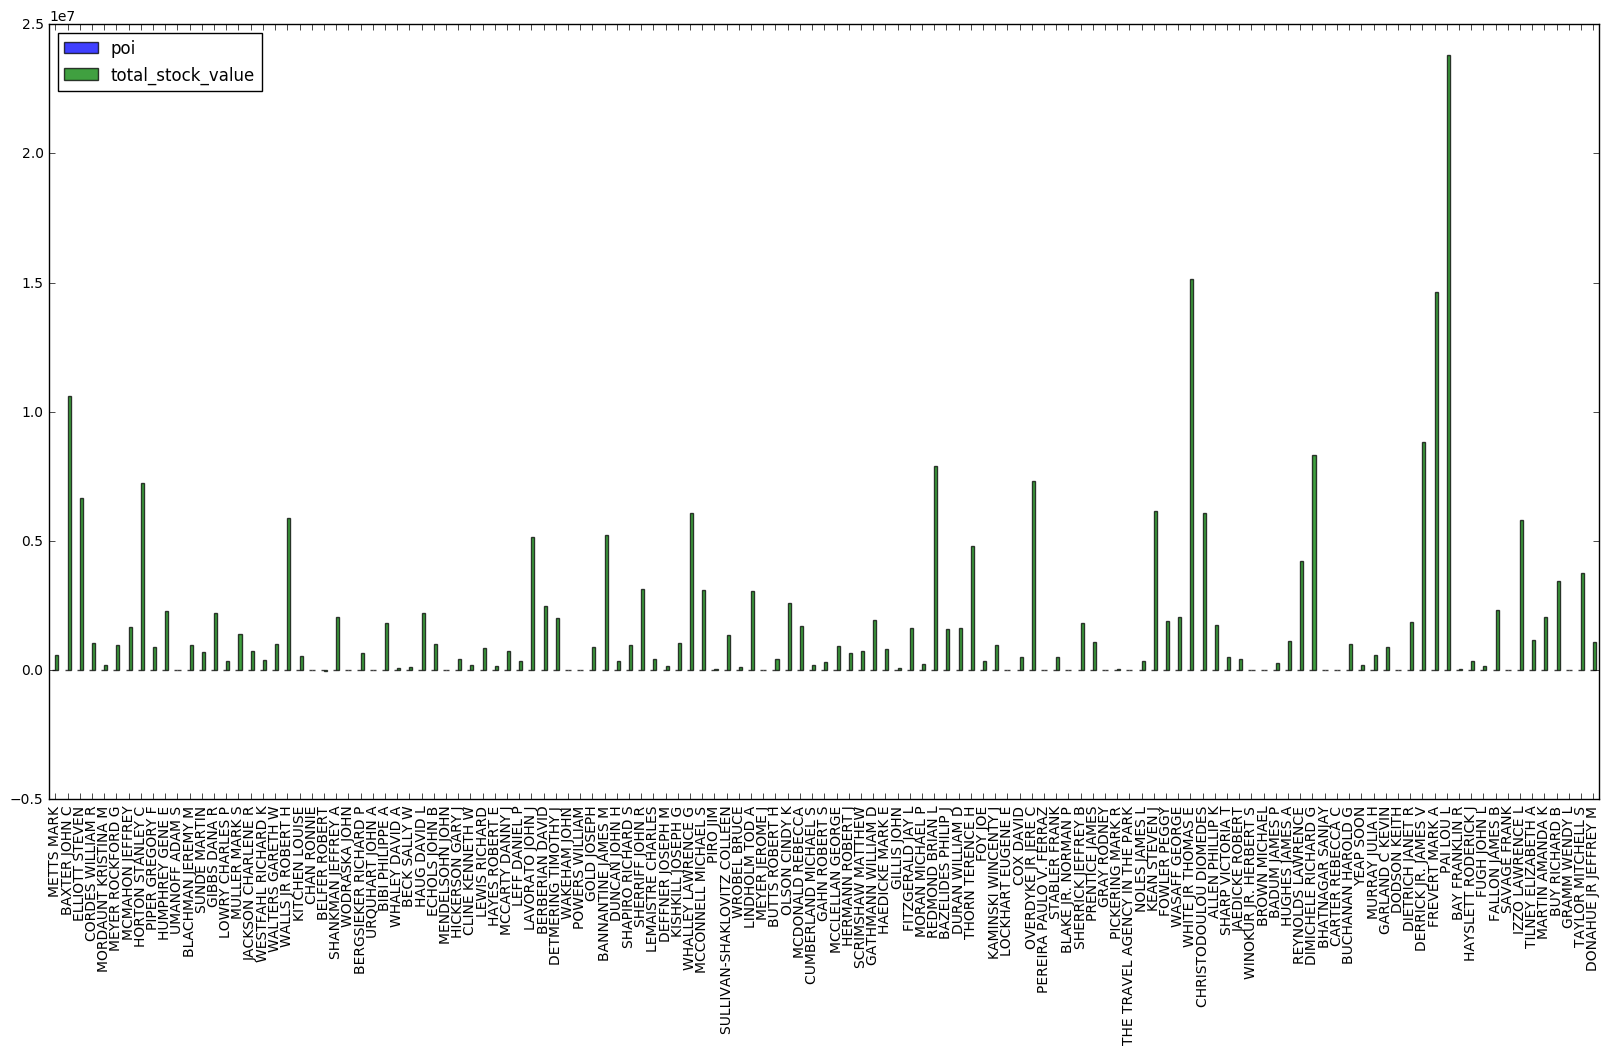

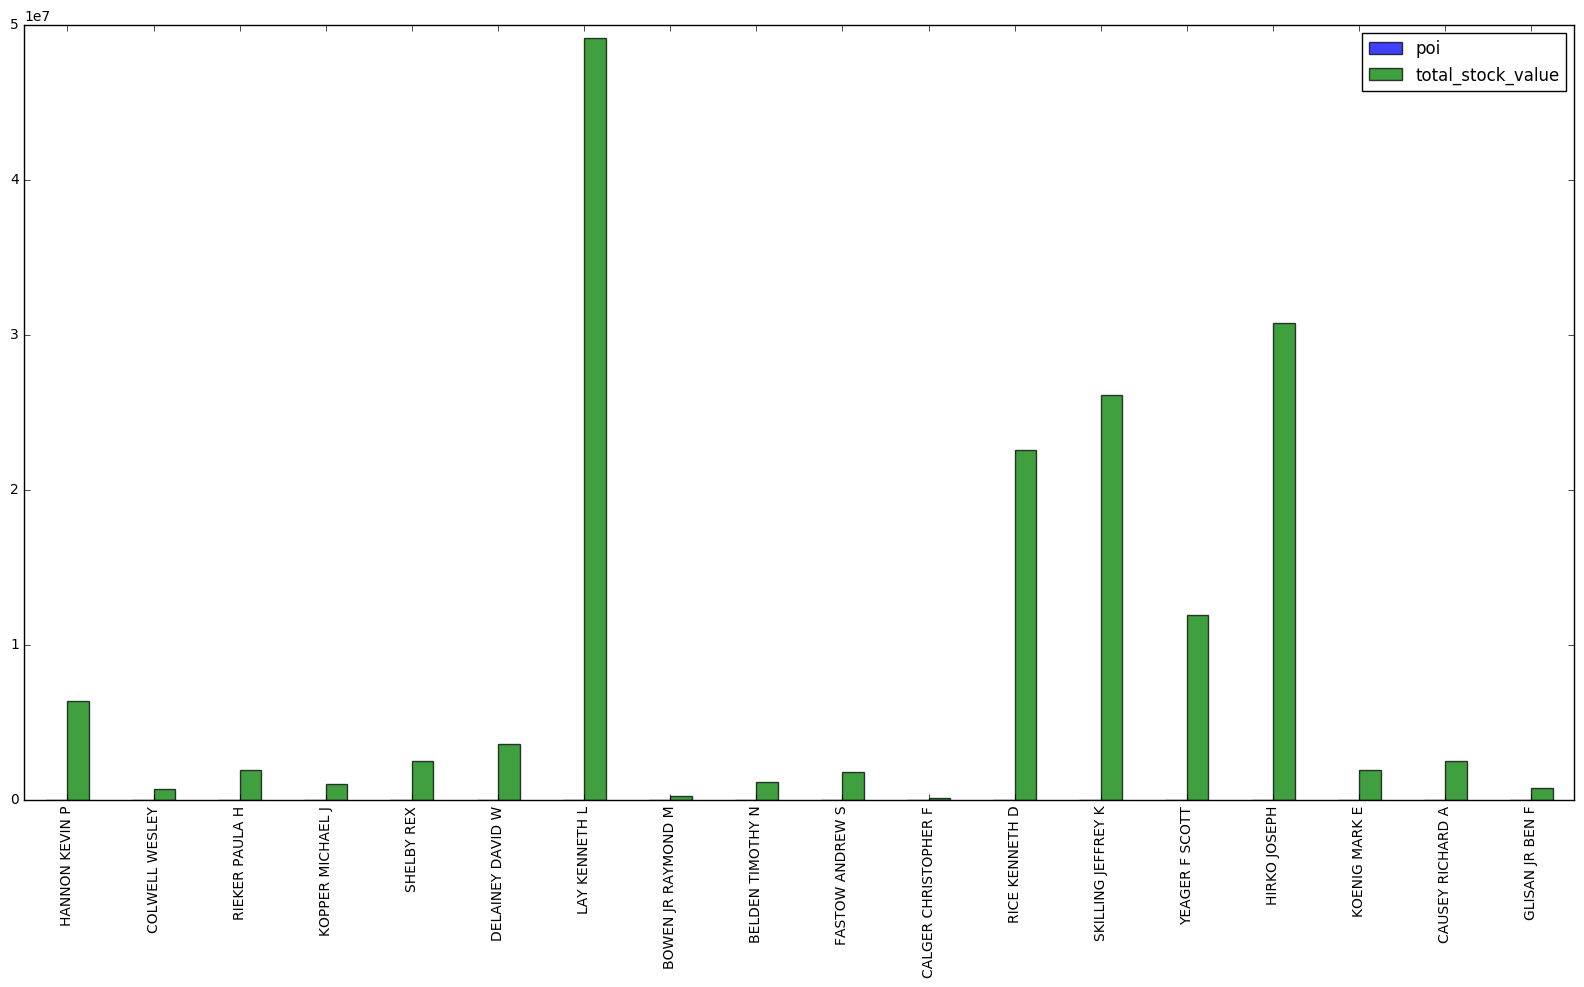

In [8]:
for ind in df_new:
    if ind != 'poi':
        print '\n', ind
        df_temp = df_new[['poi', ind]].fillna(0).copy()
        df_temp_grp = df_temp.groupby('poi')
        df_temp_grp.plot(kind='bar',alpha=0.75, rot=90, figsize=(20, 10)) 
        plt.show()

Although there are some unusual data points, leave them in because they may be valuable information. However, remove data for the travel agency in the park. It reveals no information.

## Step 2: Creating and Selecting the Right Features

### Section 1: Create new features

In [5]:
# Remove second outlier
df_new.drop(df_new.index[df_new.index.get_loc('THE TRAVEL AGENCY IN THE PARK')], inplace=True)

# Create new features
df_new['fraction_to_poi'] = df_new['from_this_person_to_poi']/df_new['from_messages']
df_new['fraction_from_poi'] = df_new['from_poi_to_this_person']/df_new['to_messages']
df_new['fraction_shared_with_poi'] = df_new['shared_receipt_with_poi']/df_new['to_messages']

# Create new features list
new_features_list = list(df_new.columns.values)

# Make poi as the first feature of the list
new_features_list.remove('poi')
new_features_list.insert(0,'poi')

# Replace numpy type NaNs to string NaNs so featureFormat can take care of them 
df_new = df_new.replace(np.nan,'NaN', regex=True)

# Convert df back to a dict:
df_dict = df_new.to_dict('index')

# Use the new dictionary as the dataset
my_dataset = df_dict

# Select all features to use in SelectKBest
all_features = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 
                'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
                'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 
                'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                'shared_receipt_with_poi', 'fraction_to_poi', 'fraction_from_poi', 'fraction_shared_with_poi']


### Section 2: Select the Features using SelectKBest

In [6]:
# Import all the necessary tools
from tester import test_classifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Use featureFormat to divide the set into featuresa and label then divide the set into train and test sets.
data = featureFormat(my_dataset, all_features, sort_keys = True)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

#Define a function that gets the name and scores of the best features
def get_best_features(features, labels):
    selector = SelectKBest(k = 12)   
    
    # fit the selector object to the features and labels
    selected_features = selector.fit(features, labels)
    scores = selected_features.scores_
    pvalues = selected_features.pvalues_
    
    # get indices of the selected features
    feature_indices = selected_features.get_support(indices=True)
    
    # get the names of the selected features
    chosen_feature_names = [all_features[i+1] for i in feature_indices]
    
    # for each selected feature, create a tuple of feature name, score, and pvalue 
    features_scores_values = [(all_features[i+1], scores[i], pvalues[i]) for i in feature_indices]
    
    # sort the tuples by score
    sorted_features = sorted(features_scores_values, key = lambda results: results[1], reverse=True)
    
    print "The best features according to SelectKBest are:" '\n'
    print chosen_feature_names, '\n'
    print "The scores and pvalues for the selected features are:" '\n'
    for item in sorted_features:
        print item

get_best_features(features, labels)

The best features according to SelectKBest are:

['salary', 'total_payments', 'loan_advances', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'shared_receipt_with_poi', 'fraction_to_poi', 'fraction_shared_with_poi'] 

The scores and pvalues for the selected features are:

('exercised_stock_options', 24.815079733218194, 1.8182048777865317e-06)
('total_stock_value', 24.182898678566879, 2.4043152760436886e-06)
('bonus', 20.792252047181535, 1.10129873239521e-05)
('salary', 18.289684043404513, 3.4782737683651706e-05)
('fraction_to_poi', 16.409712548035792, 8.3889533567042162e-05)
('deferred_income', 11.458476579280369, 0.00092203670846723062)
('long_term_incentive', 9.9221860131898225, 0.0019941812453537077)
('restricted_stock', 9.2128106219771002, 0.002862802957909168)
('fraction_shared_with_poi', 9.1012687391935039, 0.0030312943103536103)
('total_payments', 8.7727777300916756, 0.0035893261725153044)
('shared_receipt_w

The top ten features seem to be 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'fraction_to_poi', 'deferred_income', 'long_term_incentive', 'restricted_stock', 'fraction_shared_with_poi', and 'total_payments.' However, the number of features and number of dimensions were arbitraily chosen. Therefore, more scientific way is needed to select the best features. For this, Grid Search will be used. 

## Step 3: Select the Algorithm

In [7]:
# Assign all the classifiers and tools; they will be used in the function below.
scaler = MinMaxScaler()
skb = SelectKBest()
gnb = GaussianNB()
pca = PCA()
svc = SVC()
dt = tree.DecisionTreeClassifier()
kn = KNeighborsClassifier(n_neighbors=7)
rf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

def scores(classifier, number_top_features, number_dimensions):
    # Use pipeline to construct the classifier
    skb = SelectKBest(k = number_top_features)
    pca = PCA(n_components = number_dimensions)
    clf = Pipeline(steps=[('scaling',scaler), ('SKB', skb), ('pca',pca), ('algorithm', classifier)])
    
    # Fit pipeline to training data:
    clf.fit(features_train, labels_train)
    
    # Show the performance of the classifier
    test_classifier(clf, my_dataset, all_features)

In [8]:
scores(gnb, 10, 5)

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C2E3828>)), ('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('algorithm', GaussianNB(priors=None))])
	Accuracy: 0.82113	Precision: 0.31288	Recall: 0.28550	F1: 0.29856	F2: 0.29059
	Total predictions: 15000	True positives:  571	False positives: 1254	False negatives: 1429	True negatives: 11746



In [9]:
scores(svc, 10, 5)

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C2E3828>)), ('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('algorithm', SVC(C=1.0...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.86660	Precision: 0.33333	Recall: 0.00050	F1: 0.00100	F2: 0.00062
	Total predictions: 15000	True positives:    1	False positives:    2	False negatives: 1999	True negatives: 12998



In [10]:
scores(dt, 10, 5)

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C2E3828>)), ('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('algorithm', DecisionT...it=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.79560	Precision: 0.23270	Recall: 0.23200	F1: 0.23235	F2: 0.23214
	Total predictions: 15000	True positives:  464	False positives: 1530	False negatives: 1536	True negatives: 11470



In [11]:
scores(kn, 10, 5)

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C2E3828>)), ('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('algorithm', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform'))])
	Accuracy: 0.84980	Precision: 0.06228	Recall: 0.00900	F1: 0.01573	F2: 0.01086
	Total predictions: 15000	True positives:   18	False positives:  271	False negatives: 1982	True negatives: 12729



In [12]:
scores(rf, 10, 5)

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C2E3828>)), ('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('algorithm', RandomFor...estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False))])
	Accuracy: 0.83933	Precision: 0.28421	Recall: 0.13500	F1: 0.18305	F2: 0.15084
	Total predictions: 15000	True positives:  270	False positives:  680	False negatives: 1730	True negatives: 12320



The important metric to evaluate the algorithm would be F1 for this data set. Therefore, Gaussian NB and Decision Tree are the two best algorithms. Grid Search CV will be used for cross validation and finding the best algorithms.

## Step 4: GridSearchCV

In [13]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV


# create parameters for classifiers to be used in pipeline
params_gnb = {
        'SKB__k' : [5, 6, 7, 8, 9, 10, 11, 12]
        }

params_dt = {
        'SKB__k' : [5, 6, 7, 8, 9, 10, 11, 12],
        'algo__min_samples_split' : [2, 4, 6, 8, 10, 15, 20, 25, 30],
        'algo__criterion' : ['gini', 'entropy']
        }

# tune classifier and obtain scores based on parameters above
def get_scores(classifier, parameters):
    steps = [('scaling',scaler), ('SKB', skb), ('algo', classifier)]
    pipeline = Pipeline(steps)
    cv = StratifiedShuffleSplit(labels, n_iter=100, random_state = 42)
    gs = GridSearchCV(pipeline, parameters, n_jobs = -1, cv=cv, scoring="f1")
    gs.fit(features, labels)
    clf = gs.best_estimator_
    features_selected = [all_features[i+1] for i in clf.named_steps['SKB'].get_support(indices=True)]
    print 'The features selected by SelectKBest:'
    print features_selected, '\n'
    print "The best parameters: ", gs.best_params_, '\n' 
    dump_classifier_and_data(clf, my_dataset, all_features)
    print "Tester Classification report" 
    test_classifier(clf, my_dataset, all_features)

In [26]:
get_scores(gnb, params_gnb)

The features selected by SelectKBest:
['salary', 'bonus', 'total_stock_value', 'exercised_stock_options', 'fraction_to_poi'] 

The best parameters:  {'SKB__k': 5} 

Tester Classification report
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=5, score_func=<function f_classif at 0x000000000BBDF588>)), ('algo', GaussianNB(priors=None))])
	Accuracy: 0.84947	Precision: 0.42153	Recall: 0.34650	F1: 0.38035	F2: 0.35929
	Total predictions: 15000	True positives:  693	False positives:  951	False negatives: 1307	True negatives: 12049



In [36]:
get_scores(dt, params_dt)

The features selected by SelectKBest:
['salary', 'total_payments', 'loan_advances', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'shared_receipt_with_poi', 'fraction_to_poi', 'fraction_shared_with_poi'] 

The best parameters:  {'algo__criterion': 'entropy', 'algo__min_samples_split': 25, 'SKB__k': 12} 

Tester Classification report
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=12, score_func=<function f_classif at 0x000000000BBDF588>)), ('algo', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=25, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.82487	Precision: 0.36505	Recall: 0.42400	F1: 0.39232	F2: 0.41073
	Total predictions: 15000	T

Decision Tree should be used! I now have an algorithm to detect the criminals in Enron case.

## Step 5: Additional Analysis

### Was I smart to add new features?

In [15]:
# Select only the old features
old_features = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 
                'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
                'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 
                'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                'shared_receipt_with_poi']

# Use featureFormat to divide the set into featuresa and label then divide the set into train and test sets.
data = featureFormat(my_dataset, old_features, sort_keys = True)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# get the best score using old features
def get_old_scores(classifier, parameters):
    steps = [('scaling',scaler), ('SKB', skb), ('algo', classifier)]
    pipeline = Pipeline(steps)
    cv = StratifiedShuffleSplit(labels, n_iter=100, random_state = 42)
    gs = GridSearchCV(pipeline, parameters, n_jobs = -1, cv=cv, scoring="f1")
    gs.fit(features, labels)
    clf = gs.best_estimator_
    features_selected = [old_features[i+1] for i in clf.named_steps['SKB'].get_support(indices=True)]
    print 'The features selected by SelectKBest:'
    print features_selected, '\n'
    print "The best parameters: ", gs.best_params_, '\n'
    print "Tester Classification report" 
    test_classifier(clf, my_dataset, old_features)

In [16]:
get_old_scores(dt, params_dt)

The features selected by SelectKBest:
['salary', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options'] 

The best parameters:  {'algo__criterion': 'gini', 'algo__min_samples_split': 2, 'SKB__k': 5} 

Tester Classification report
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=5, score_func=<function f_classif at 0x000000000C2E3828>)), ('algo', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.80573	Precision: 0.27173	Recall: 0.27200	F1: 0.27186	F2: 0.27195
	Total predictions: 15000	True positives:  544	False positives: 1458	False negatives: 1456	True negatives: 11542



In [ ]:
get_scores(dt, params_dt)